In [117]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import sys
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

from sklearn.model_selection import GridSearchCV

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")
drive= os.join(root, "code", "drive")

plots= os.join(root, "code", "plots")

In [118]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [119]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


In [120]:
# load codebook        
codebk = drive.CreateFile({'id': '1Lf7kV9_R-caFZV6_l8hMxAVjFSVFhvYl'})
codebk.GetContentFile('codebook.xlsx')

codebk= pd.read_excel('codebook.xlsx', sheet_name = "predictors")
codebk.head()

C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Source,Notes,Include_BBL,Include_Box
0,geofips,census tract geo identifier,Census ACS,NaN,0.0,0.0
1,geofips_recode,"census tract geo identifier, changes county to...",Census ACS,NaN,0.0,0.0
2,totpop,total population,Census ACS,NaN,1.0,1.0
3,popdens,total population per square mile,Census ACS,NaN,1.0,1.0
4,areasqmile,area,Census ACS,NaN,1.0,1.0


In [121]:
predictors_full = codebk.loc[codebk["Include_Box"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2            totpop
3           popdens
4        areasqmile
5             males
6           females
           ...     
164    bldgclass_A2
165    bldgclass_A0
166    bldgclass_A6
167    bldgclass_A8
168    bldgclass_CM
Name: Variable, Length: 150, dtype: object

## Load analysis file

In [122]:
df_box = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
df_box.GetContentFile('analysis_box.csv')

df_box= pd.read_csv('analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsamecounty,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,3.130277,0.0,0.0,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,3.130277,0.0,0.0,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,3.130277,0.0,0.0,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,3.130277,0.0,0.0,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,3.130277,0.0,0.0,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333


In [123]:
print("75th percentile:", df_box["num_fire_ev"].quantile(q = 0.75))
print("Max:", df_box["num_fire_ev"].max())
print("25th percentile:", df_box["num_fire_ev"].quantile(q = 0.25))
print("Min:", df_box["num_fire_ev"].min())

75th percentile: 31.0
Max: 1288
25th percentile: 5.0
Min: 1


In [124]:
df_box.sort_values("num_fire_ev", ascending = False)

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsamecounty,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
459,B0762,2331.575758,4766.803030,1.037879,3.037879,5.265152,5.333333,19280.681818,2.416009e+05,54776.916667,...,3.130277,0.0,0.0,0.948175,1.0,3.012422,2.043478,56.043478,1288,80.500000
10287,X3386,7516.195122,18484.560976,1.146341,3.493902,17.317073,17.365854,53304.926829,3.654586e+05,51617.975610,...,3.130277,0.0,0.0,0.948175,1.0,2.859406,1.928713,60.390099,1010,59.411765
3183,M1349,29102.250000,70250.250000,1.250000,5.500000,56.250000,60.000000,706726.750000,4.393124e+06,483300.000000,...,3.130277,0.0,0.0,0.948175,1.0,3.136268,2.083857,32.469602,954,56.117647
1007,B1550,6282.846154,19301.879121,1.054945,4.010989,18.945055,19.340659,129306.736264,6.079176e+05,62048.846154,...,3.130277,0.0,0.0,0.948175,1.0,2.941392,2.164835,33.959707,819,48.176471
10091,X2942,4290.222222,14230.500000,1.111111,4.333333,16.500000,16.888889,62995.000000,4.241367e+05,210241.000000,...,3.130277,0.0,0.0,0.948175,1.0,3.120690,2.045977,39.764368,696,40.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,Q4292,2527.302083,2690.135417,1.031250,2.125000,2.145833,2.145833,22094.375000,7.093812e+04,6973.500000,...,3.130277,0.0,0.0,0.948175,1.0,0.000000,0.000000,0.000000,1,0.000000
4532,Q4307,9461.600000,17690.000000,1.200000,3.600000,15.800000,15.800000,144528.000000,8.193420e+05,31940.400000,...,3.130277,0.0,0.0,0.948175,1.0,0.000000,0.000000,0.000000,1,0.000000
6265,Q6779,4439.226190,1554.047619,1.380952,1.775595,1.059524,1.059524,18240.714286,4.875857e+04,2645.000000,...,3.130277,0.0,0.0,0.948175,1.0,1.000000,1.000000,58.000000,1,1.000000
6258,Q6770,4201.509434,1405.528302,1.490566,1.665849,1.000000,1.000000,17111.320755,4.500340e+04,2797.547170,...,3.130277,0.0,0.0,0.948175,1.0,0.000000,0.000000,0.000000,1,0.000000


In [125]:
assert df_box.dropna().shape[0] == df_box.shape[0]

In [126]:
df_box.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]

predictors_acs= df_box.columns[df_box.columns.get_loc("totpop"):df_box.columns.get_loc("pctrentocch") + 1].tolist()
landusecols= [x for x in df_box.columns if x in 'landuse_']
bldgclasscols= [x for x in df_box.columns if x in 'bldgclass_']

predictors_full= predictors + predictors_acs  + landusecols + bldgclasscols
predictors_full;

In [127]:
## create discrete outcome
df_box["num_fire_ev_quart"]= pd.qcut(df_box["num_fire_ev"], 4, labels = False)
df_box["num_fire_ev_quart"].value_counts()

df_box["num_fire_ev_ind"]= np.where(df_box["num_fire_ev_quart"] == 3, 1, 0)

In [128]:
outcomes= ["dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"]
df_box[outcomes].head()

,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,32.666667,6,1.200000
1,42.333333,3,3.000000
2,36.880000,25,1.923077
3,15.600000,5,1.666667
4,32.181818,44,2.933333


# (0) Prep data

In [129]:
df_box.describe()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,num_fire_ev_quart,num_fire_ev_ind
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,10864.0,1.086400e+04,10864.0,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357522e+04,2.571084e+04,1.933247,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.620042,...,0.0,9.481751e-01,1.0,2.696305,1.891626,40.335653,27.951859,2.381331,1.470453,0.249816
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.844576,...,0.0,3.630596e-14,0.0,1.179745,0.752555,18.500212,48.572309,2.800509,1.134940,0.432926
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,0.0,9.481751e-01,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226809e+03,1925.107672,...,0.0,9.481751e-01,1.0,2.090909,1.571429,32.290179,5.000000,1.200000,0.000000,0.000000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,0.0,9.481751e-01,1.0,2.909091,2.000000,40.333333,13.000000,1.666667,1.000000,0.000000
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,0.0,9.481751e-01,1.0,3.312500,2.250000,49.910985,31.000000,2.538462,2.000000,0.000000
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,0.0,9.481751e-01,1.0,23.928571,13.500000,450.000000,1288.000000,80.500000,3.000000,1.000000


In [130]:
df_box.loc[df_box["avg_fire_ev_yr"]==0].shape[0]/df_box.shape[0]

0.0625920471281296

In [131]:
# assert no missingness
assert (df_box.isna().sum(axis = 0).sum() == 0)

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X = df_box.loc[:, predictors_full]
y = df_box.loc[X.index, outcomes]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

### Running LASSO to determine important variables

In [132]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_scaled, y, test_size=0.3, random_state=999)

In [133]:
from sklearn import linear_model

coef_comp= pd.DataFrame(X.columns, columns = ['Features'])
coef_comp

param_grid= {'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
clf= linear_model.Lasso(fit_intercept = True)
gr = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)
rs = gr.fit(X_train_l, y_train_l.iloc[:, 1])

print(rs.best_params_)
print(rs.best_score_)

clf= linear_model.Lasso(fit_intercept = True, alpha = rs.best_params_['alpha'])
clf.fit(X_train_l, y_train_l.iloc[:, 1])
coef_comp['coef_alpha_0.1']= clf.coef_

{'alpha': 0.1}
0.2469150941482355


In [134]:
clf= linear_model.Lasso(fit_intercept = True, alpha = 3)
clf.fit(X_train_l, y_train_l.iloc[:, 1])

# feature selection from LASSOs
# fewer features chosen
coef_comp['coef_alpha_3']= clf.coef_
lasso_coef= coef_comp.loc[coef_comp['coef_alpha_0.1'] != 0].sort_values('coef_alpha_0.1', ascending = False)
lasso_coef

,Features,coef_alpha_0.1,coef_alpha_3
16,viol_count_per_unit,9.263723,7.057609
24,popdens,8.281352,6.669201
34,popnhblack,7.606042,5.441547
3,numfloors,6.776439,1.480824
70,popsamehouse,6.214268,0.308154
14,hpd_fire_vio,5.335933,3.263850
49,roc_half_1,3.928316,1.040611
28,pop18under,3.440628,0.000000
6,assessland,3.349122,0.000000
10,holc_AB,2.976364,0.000000


In [135]:
lasso_coef.loc[lasso_coef["coef_alpha_3"] != 0, :]

,Features,coef_alpha_0.1,coef_alpha_3
16,viol_count_per_unit,9.263723,7.057609
24,popdens,8.281352,6.669201
34,popnhblack,7.606042,5.441547
3,numfloors,6.776439,1.480824
70,popsamehouse,6.214268,0.308154
14,hpd_fire_vio,5.335933,3.263850
49,roc_half_1,3.928316,1.040611
12,holc_D,2.956772,1.555186
63,hhfoilkerosene,1.273458,0.301817
17,hpd_fire_vio_per_unit,0.945728,0.571662


# (1) Decision Trees and Random Forest Models
* All are negative, suggests the model isn't performing very well

In [19]:
from sklearn.metrics import mean_squared_error
for c in range(3):
    print("\nDecision tree for", outcomes[c])
    print()
    
    dt1 = DecisionTreeRegressor(max_depth=10, random_state = 99)
    dt1.fit(X_train, y_train.iloc[:, c])

    dt2 = DecisionTreeRegressor(max_depth=15, random_state = 99)
    dt2.fit(X_train, y_train.iloc[:, c])

    y_pred1= dt1.predict(X_test)
    y_pred2= dt2.predict(X_test)

    print("R2 for model 1:", dt1.score(X_test, y_test.iloc[:, c]))
    print("R2 for model 2:", dt2.score(X_test, y_test.iloc[:, c]))
    
    print("\nMSE for model 1:", mean_squared_error(y_test.iloc[:, c], y_pred1))
    print("MSE for model 2:", mean_squared_error(y_test.iloc[:, c], y_pred2))


Decision tree for dispatch_response_seconds_qy

R2 for model 1: -0.2539904312169927
R2 for model 2: -0.5204322883545001

MSE for model 1: 466.55968902599915
MSE for model 2: 565.6920483446758

Decision tree for num_fire_ev

R2 for model 1: -0.3442636811435651
R2 for model 2: -0.39957846084260473

MSE for model 1: 3405.7364399099115
MSE for model 2: 3545.8782614358397

Decision tree for avg_fire_ev_yr

R2 for model 1: -0.3103923618085451
R2 for model 2: -0.6413683718477088

MSE for model 1: 11.205078484295143
MSE for model 2: 14.035232472516828


## Tuning
* There is a higher R2 for num_fire_ev and avg_fire_ev_yr
* Seems to do well with a simpler model

In [20]:
# use max_depth to control the complexity of the tre
param_grid = {'max_depth':np.arange(1, 20)}
bp= []
s= []
for c in range(3):
    dt=DecisionTreeRegressor(random_state = 99)
    gr=GridSearchCV(dt,param_grid=param_grid)
    rs=gr.fit(X_train,y_train.iloc[:, c])
    pred= rs.predict(X_test)
    
    bp+= [rs.best_params_]
    s+= [rs.score(X_test, y_test.iloc[:, c])]
    
    print("\nTuning decision tree for", outcomes[c])
    print(rs.best_params_)
    print("R2:",rs.score(X_test, y_test.iloc[:, c]))
    
    print("MSE:", mean_squared_error(y_test.iloc[:, c], pred))


Tuning decision tree for dispatch_response_seconds_qy
{'max_depth': 2}
R2: 0.02586193676640014
MSE: 362.4378149437498

Tuning decision tree for num_fire_ev
{'max_depth': 3}
R2: 0.21166829206465387
MSE: 1997.2644222358401

Tuning decision tree for avg_fire_ev_yr
{'max_depth': 3}
R2: 0.14817060889500744
MSE: 7.283936827430416


In [21]:
# the R2 is pretty low...
print(bp)
print(s)

[{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 3}]
[0.02586193676640014, 0.21166829206465387, 0.14817060889500744]


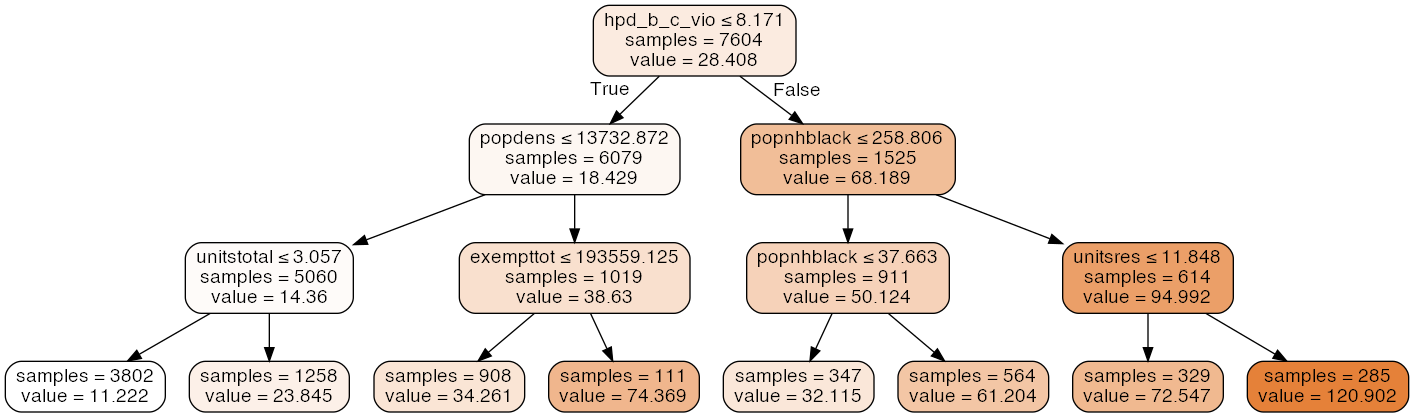

In [22]:
## can we visualize the decision tree?
## for num_fire_ev
from sklearn import tree
from IPython.display import Image  
import pydotplus

dt = DecisionTreeRegressor(max_depth= 3, random_state = 99) #bp[1]['max_depth']) # since max depth is optimal for 3, use that
dt.fit(X_train,y_train.iloc[:, 1])

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt.png'))
Image(graph.create_png())

In [24]:
## predict values for each box
pred_box= pd.concat([df_box.loc[:, "borobox"],
                    pd.DataFrame(dt.predict(df_box.loc[:, predictors_full]), columns = ['prediction_dt'])],
                                axis = 1)

## Feature Importance

In [22]:
dt = DecisionTreeRegressor(random_state = 99, max_depth= 3) #rs.best_params_['max_depth'])
dt.fit(X_train, y_train.iloc[:, 1])
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most importnat features in order (using max_depth = 10)
ft1= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft1

,variables,importance
15,hpd_b_c_vio,0.591295
34,popnhblack,0.180239
24,popdens,0.097858
4,unitsres,0.069941
8,exempttot,0.031166
5,unitstotal,0.029501
67,hhfnofuel,0.0
66,hhfotherfuel,0.0
65,hhfsolarenergy,0.0
64,hhfcoalwood,0.0


In [21]:
dt = DecisionTreeRegressor(max_depth=4, random_state = 99)
dt.fit(X_train, y_train.iloc[:, 1])
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order (using max_Depth = 4)
ft2= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft2

,variables,importance
15,hpd_b_c_vio,0.504629
34,popnhblack,0.170224
24,popdens,0.083515
4,unitsres,0.059689
5,unitstotal,0.049187
14,hpd_fire_vio,0.04514
8,exempttot,0.026598
6,assessland,0.023892
36,popnhasian,0.015759
13,tot_hpd_vio,0.012273


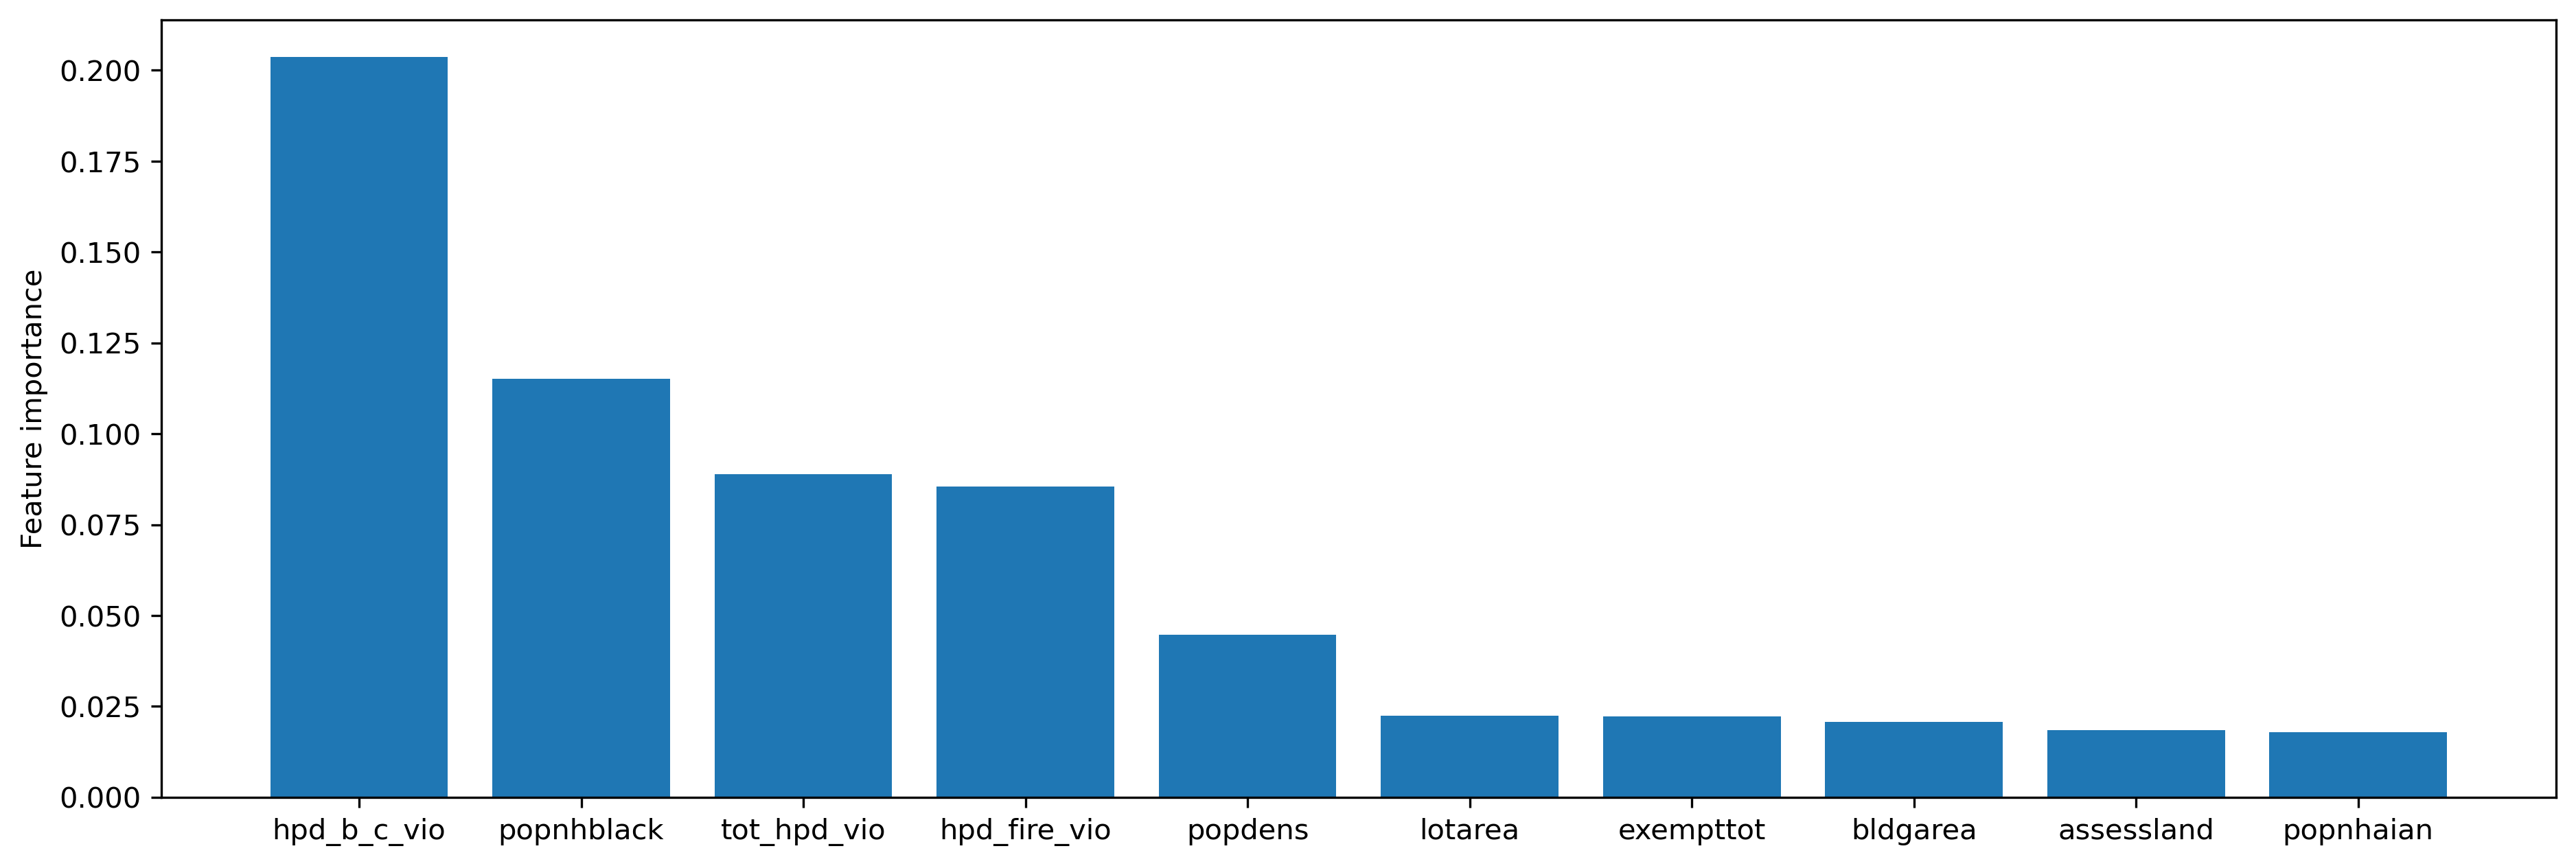

In [24]:
plt.figure(figsize=(15, 5), dpi=300)
plt.bar(ft2.sort_values(by="importance",ascending=False).iloc[:,0],
        ft2.sort_values(by="importance",ascending=False).iloc[:,1])
plt.ylabel("Feature importance")

plt.savefig(os.join(plots, "feature_impt_dt.png"))

## Random Forests
* Only outcome is number of num_fire_ev

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth = 4, random_state = 99)
rf.fit(X_train, y_train.iloc[:, 1])
y_pred=rf.predict(X_test)
print("R2 with random forest:", rf.score(X_test, y_test.iloc[:, 1]))
print("MSE:", mean_squared_error(y_test.iloc[:, 1], y_pred))

R2 with random forest: 0.23544877440355838
MSE: 1937.0157847130713


In [29]:
param_grid = {'max_depth':range(1,30)}
rf = RandomForestRegressor(n_jobs=-1, n_estimators=30, random_state = 99)
gs = GridSearchCV(rf,param_grid=param_grid)
rs = gs.fit(X_train,y_train.iloc[:, 1])
y_pred= rs.predict(X_test)

print(rs.best_params_)
print("R2 with best paramters:", rs.score(X_test, y_test.iloc[:, 1]))
print("MSE:", mean_squared_error(y_test.iloc[:, 1], y_pred))

{'max_depth': 6}
R2 with best paramters: 0.2178149592334151
MSE: 1981.691637927006


In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth = 6, random_state = 99)
rf.fit(X_train, y_train.iloc[:, 1])
y_pred=rf.predict(X_test)

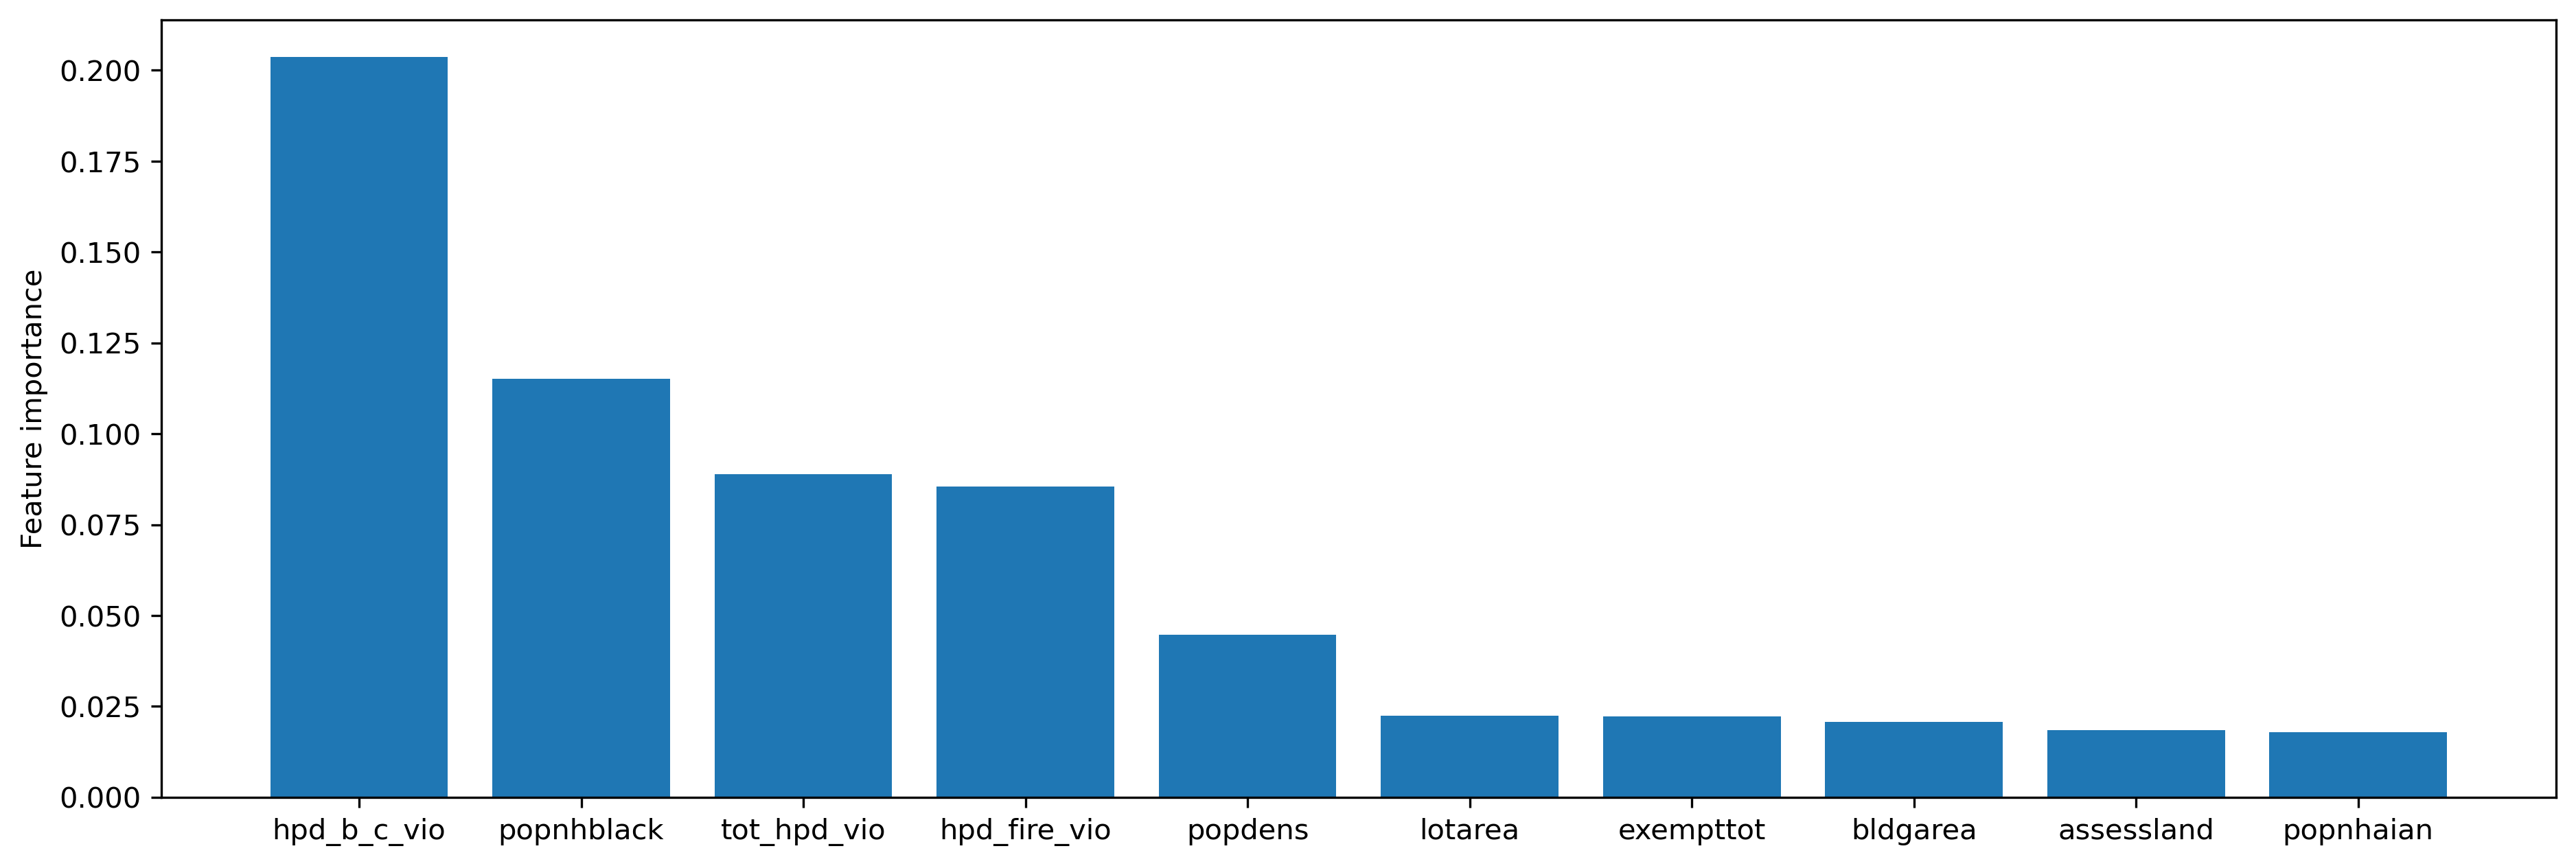

In [23]:
Feature_importance=pd.DataFrame([list(X_train.columns),list(rf.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order (using max_Depth = 4)
ft_rf= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft_rf

plt.figure(figsize=(15, 5), dpi=300)
plt.bar(ft_rf.sort_values(by="importance",ascending=False).iloc[:,0],
        ft_rf.sort_values(by="importance",ascending=False).iloc[:,1])
plt.ylabel("Feature importance")

plt.savefig(os.join(plots, "feature_impt_rf.png"))

In [31]:
## predict values for each box
pred_box2= pd.concat([pred_box,
                      df_box.loc[:, "num_fire_ev"],
                    pd.DataFrame(rf.predict(df_box.loc[:, predictors_full]), columns = ['prediction_rf'])],
                                axis = 1)
# exp prediction at box level
pred_box2.to_csv(os.join(plots, "pred_box.csv"))
pred_box2

,borobox,prediction_dt,num_fire_ev,prediction_rf
0,B0020,23.844992,6,22.006666
1,B0023,23.844992,3,18.551734
2,B0024,23.844992,25,31.420857
3,B0025,23.844992,5,17.792724
4,B0027,61.203901,44,42.183885
...,...,...,...,...
10859,X4978,23.844992,33,24.186655
10860,X4981,32.115274,12,23.461117
10861,X4982,11.222251,3,8.806100
10862,X4985,23.844992,3,11.331769


### CMM Method and Other Ensemble Methods
* [From Domingos, 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.40.2710&rep=rep1&type=pdf)
* Not an improvement in accuracy compared to decision tree model

In [32]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = 6) #rs.best_params_['max_depth'])
rf.fit(X_train,y_train.iloc[:, 1])

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.5*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [33]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([round(pd.DataFrame(y_rand)), y_train.iloc[:, 1]], axis = 0, ignore_index = True)

In [34]:
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeRegressor(random_state = 99)
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train_cmm, y_train_cmm)
y_pred = rs.predict(X_test)

print(rs.best_params_)
print("R2", rs.score(X_test, y_test.iloc[:, 1]))
print("MSE:", mean_squared_error(y_test.iloc[:, 1], y_pred))

{'max_depth': 3}
R2 0.1552961418331713
MSE: 2140.0851269327873


In [35]:
## prediction
pred = rs.predict(X_test)
pred

array([86.03070175, 41.57070064, 16.83595872, ..., 16.83595872,
       41.57070064, 51.46741416])

In [36]:
dt = DecisionTreeRegressor(max_depth= 3, random_state = 99) #rs.best_params_['max_depth']) # since max depth is optimal for 3, use that
dt.fit(X_train_cmm, y_train_cmm)

DecisionTreeRegressor(max_depth=3, random_state=99)

In [37]:
Feature_importance=pd.DataFrame([list(X_train_cmm.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most importnat features in order (using max_depth = 10)
ft3= Feature_importance.sort_values(by="importance",ascending=False)
ft3.loc[ft3['importance']>0]

,variables,importance
15,hpd_b_c_vio,0.534671
24,popdens,0.15141
34,popnhblack,0.123275
14,hpd_fire_vio,0.065871
48,roc_halfless,0.04519
16,viol_count_per_unit,0.041674
8,exempttot,0.037909


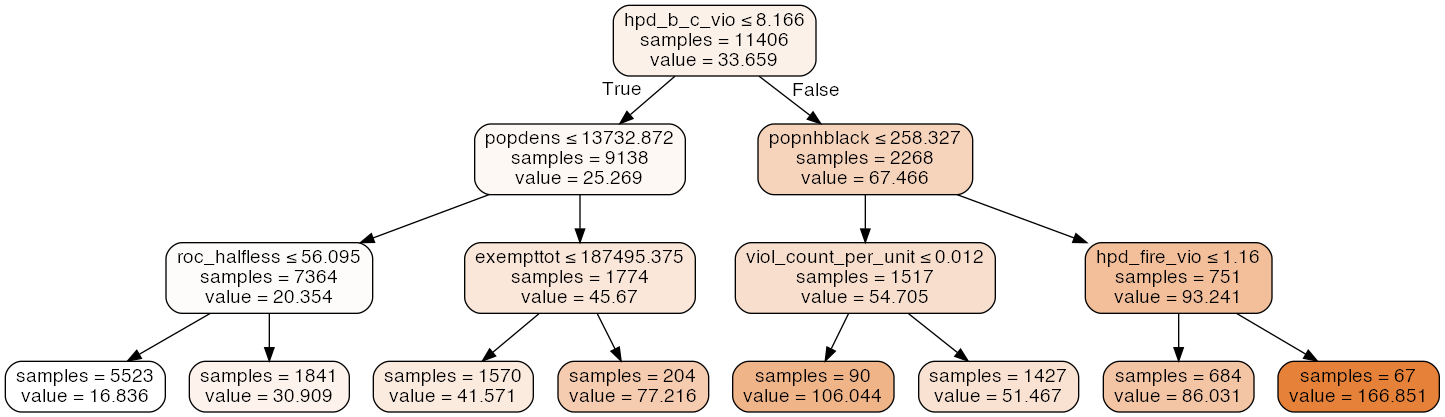

In [38]:
## we can plot this
from sklearn import tree
from IPython.display import Image  
import pydotplus

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_cmm.png'))
Image(graph.create_png())

# (1b) Run Decision Tree and Random Forest Classifier on Discrete Data

In [133]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X = df_box.loc[:, predictors_full]
y = df_box.loc[:, "num_fire_ev_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

In [134]:
from sklearn.metrics import precision_recall_fscore_support
# tune using the param grid
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier(random_state = 99)
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
pred= rs.predict(X_test)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("OS Accuracy:", np.mean(y_test == (pred > 0.5)))
print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 5}
OS Accuracy: 0.8358895705521472
ROC AUC: 0.87363978092838
Precision: 0.6824512534818942
Recall: 0.6148055207026348


In [83]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth':range(1,20)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30, random_state = 99)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc')
rs = gs.fit(X_train,y_train)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("OS Accuracy:", np.mean(y_test == (pred > 0.5)))
print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 8}
OS Accuracy: 0.851840490797546
ROC AUC: 0.8974481039586635
Precision: 0.7386018237082067
Recall: 0.6097867001254705


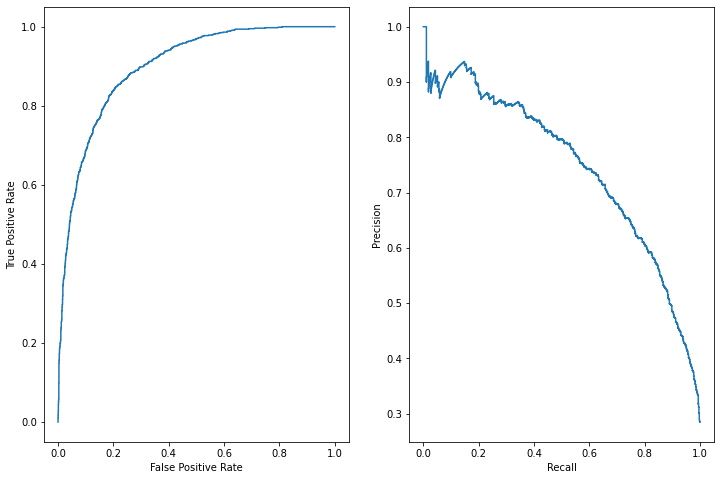

In [86]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall_boxdisc.png'))

# (2) Bayes Nets

In [146]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [147]:
## need to discretize outcomes
df_box_disc= df_box.copy()

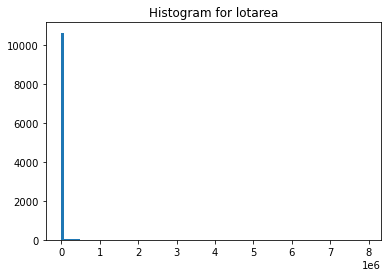

None


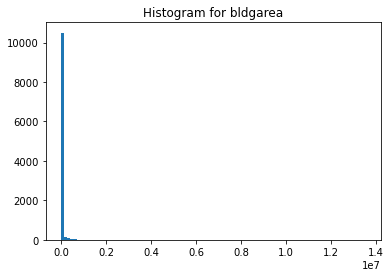

None


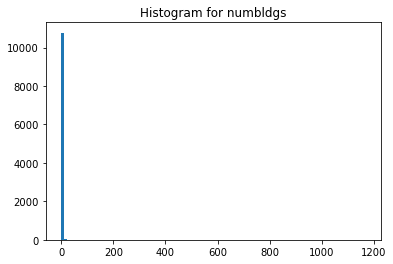

None


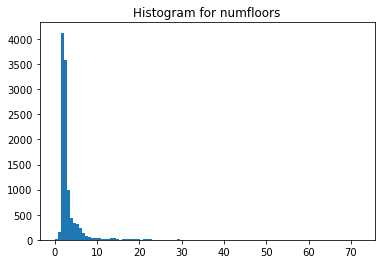

None


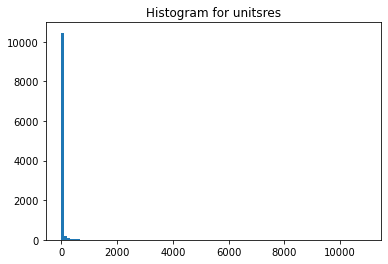

None


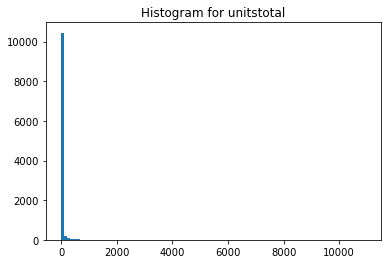

None


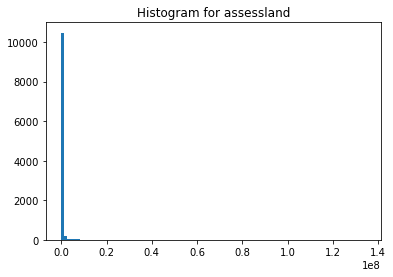

None


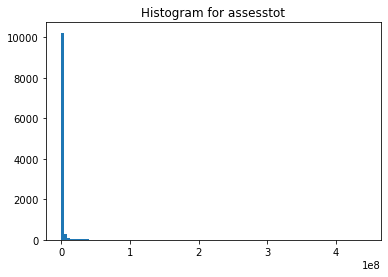

None


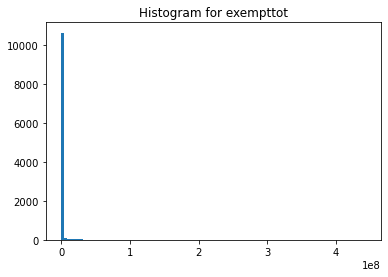

None


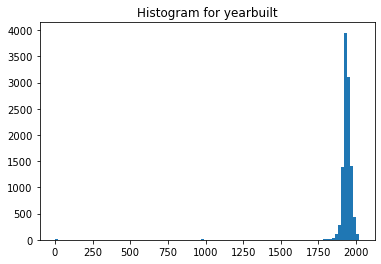

None


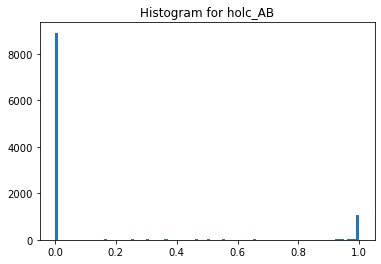

None


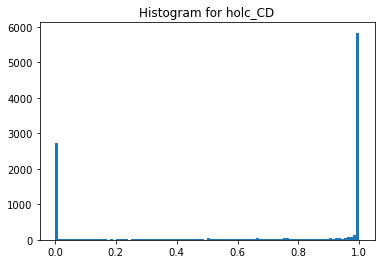

None


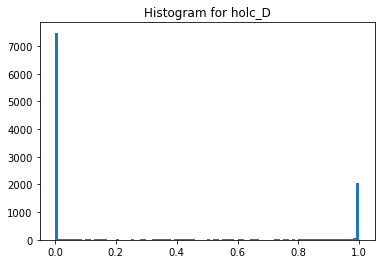

None


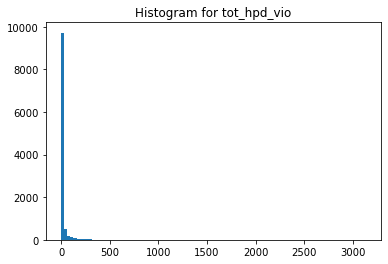

None


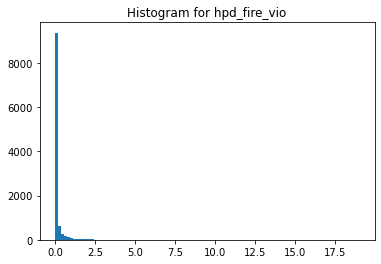

None


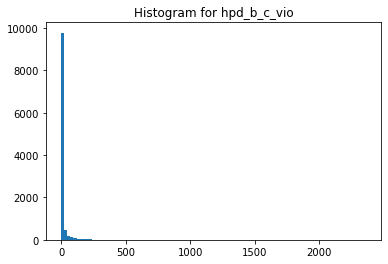

None


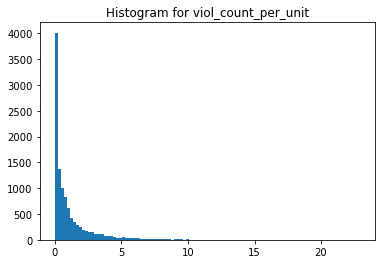

None


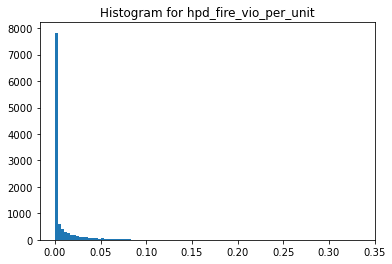

None


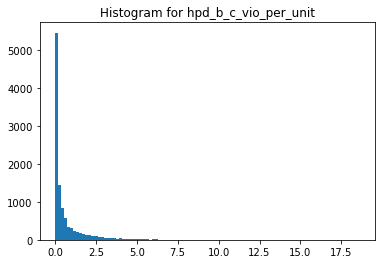

None


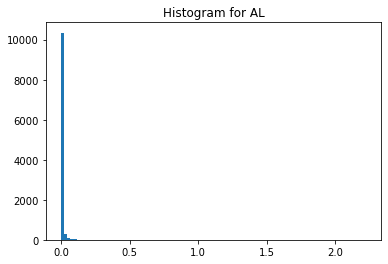

None


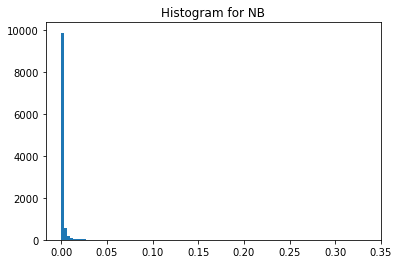

None


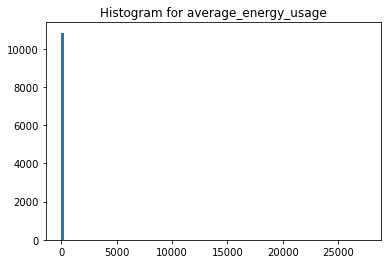

None


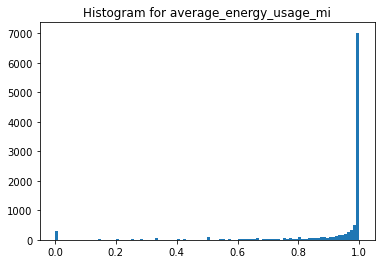

None


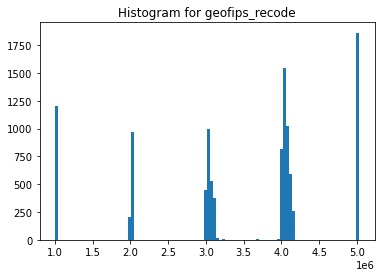

None


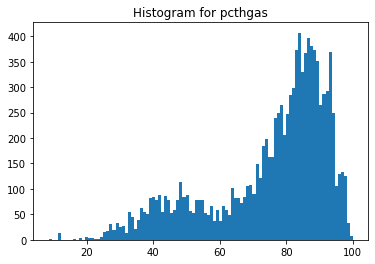

None


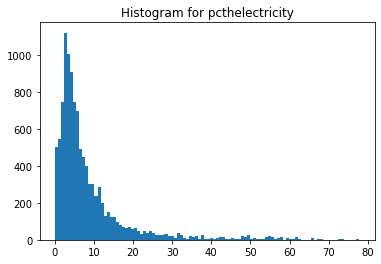

None


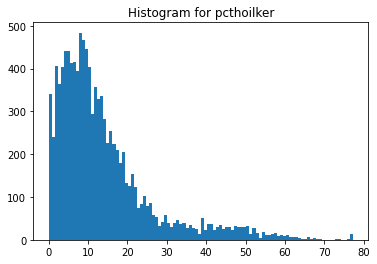

None


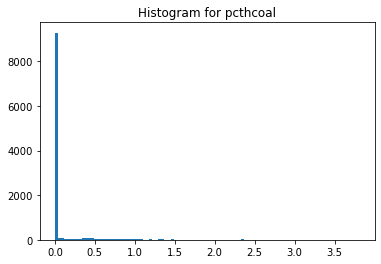

None


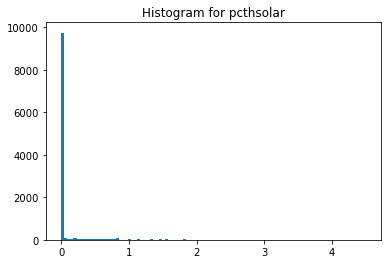

None


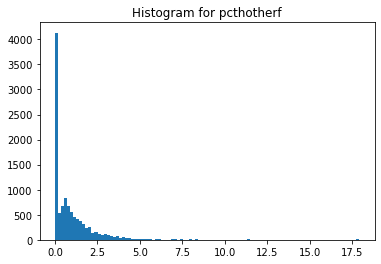

None


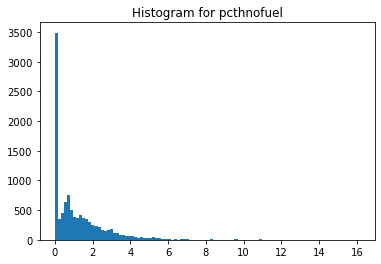

None


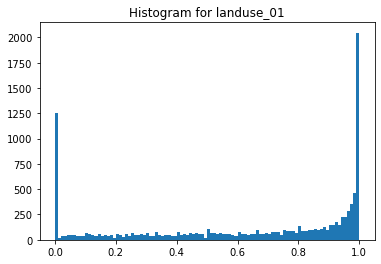

None


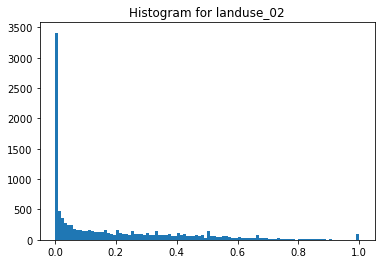

None


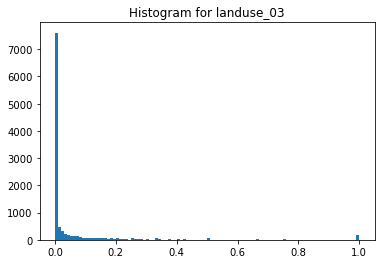

None


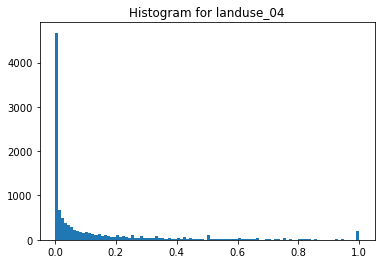

None


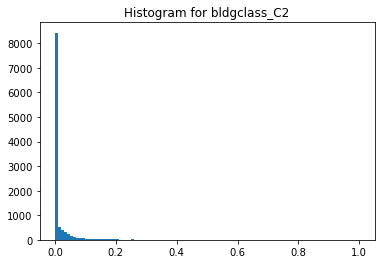

None


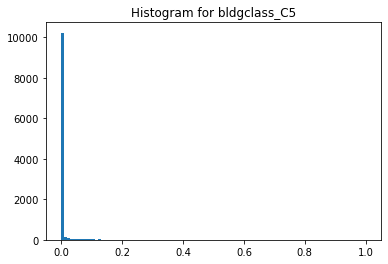

None


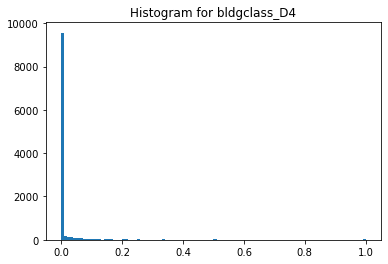

None


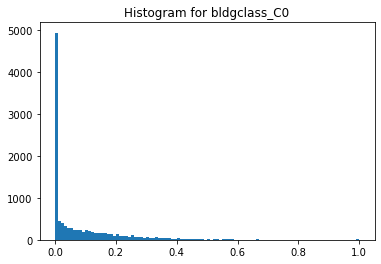

None


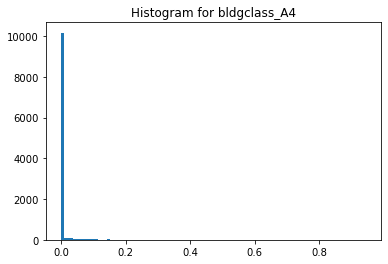

None


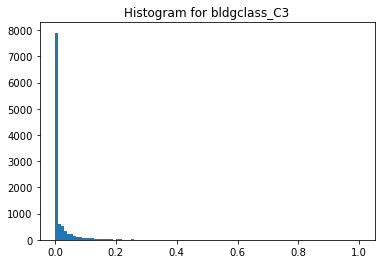

None


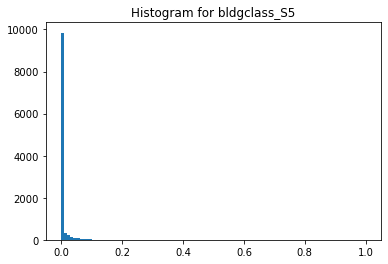

None


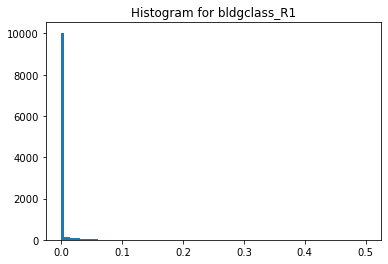

None


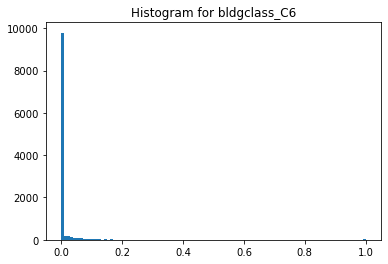

None


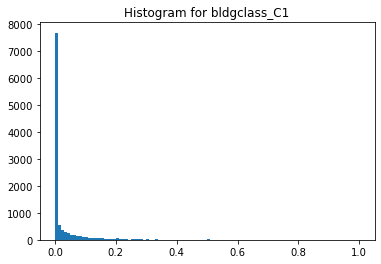

None


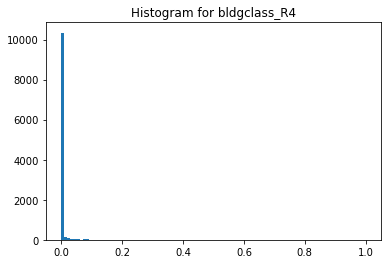

None


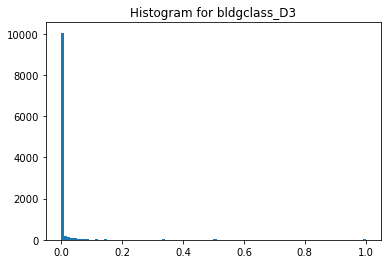

None


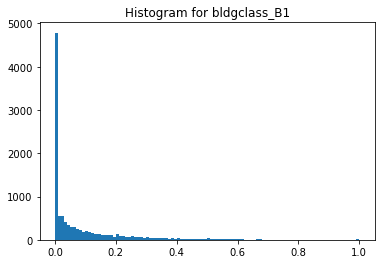

None


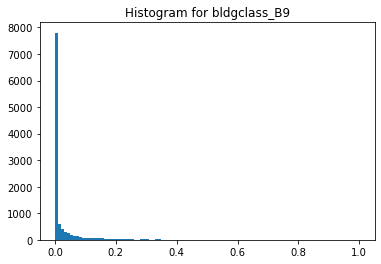

None


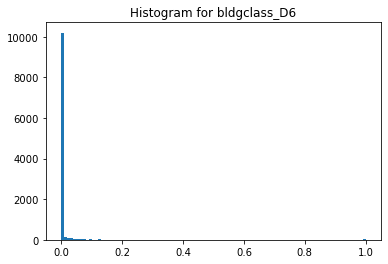

None


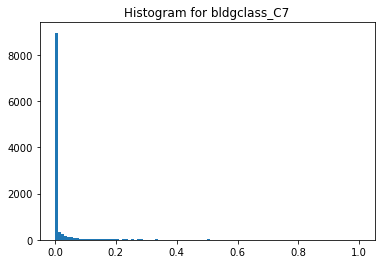

None


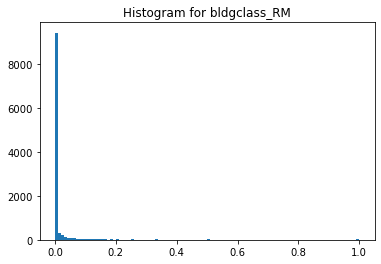

None


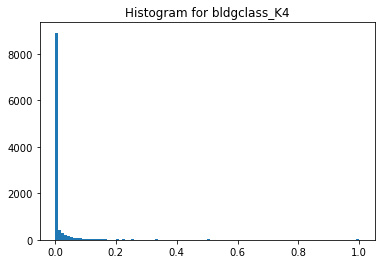

None


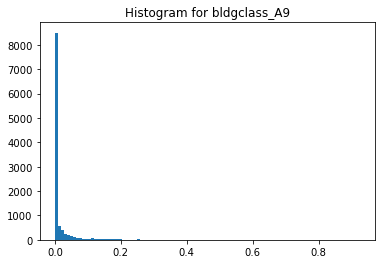

None


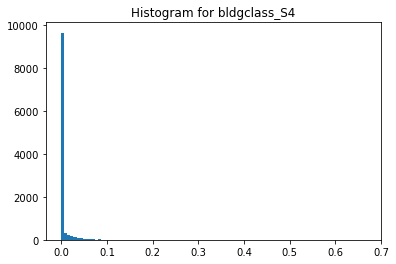

None


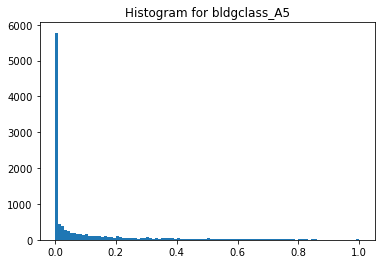

None


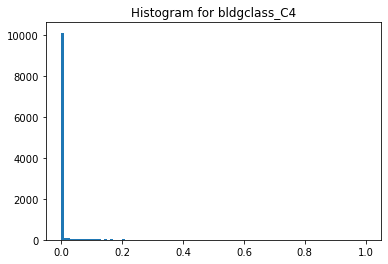

None


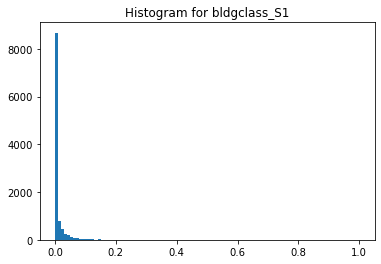

None


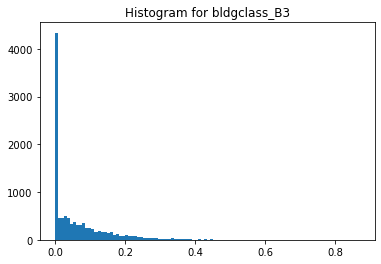

None


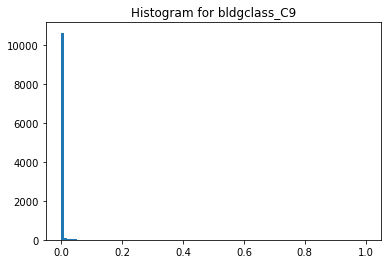

None


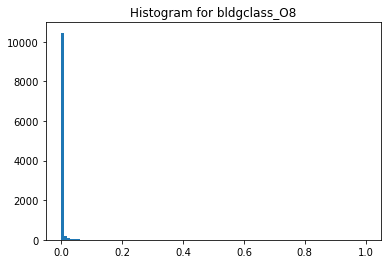

None


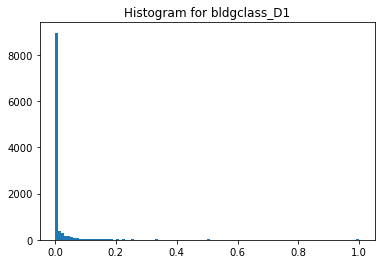

None


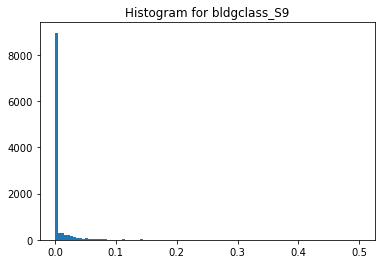

None


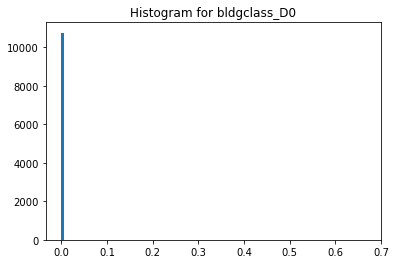

None


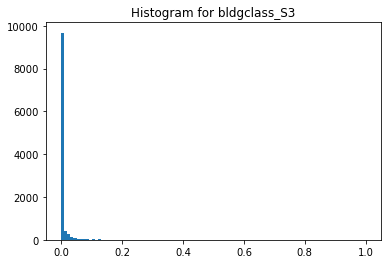

None


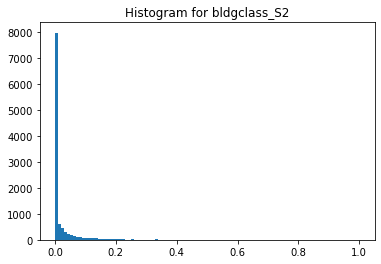

None


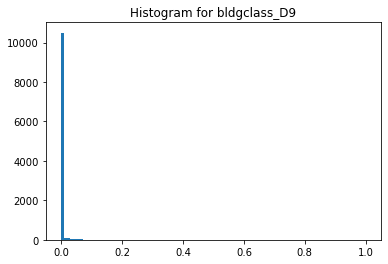

None


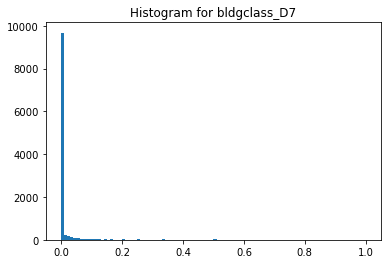

None


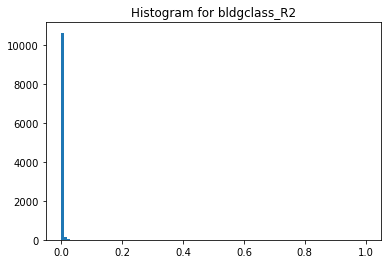

None


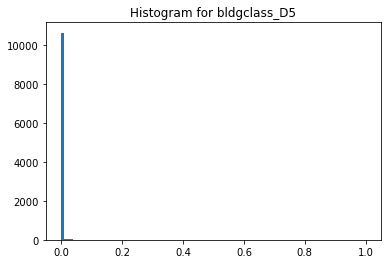

None


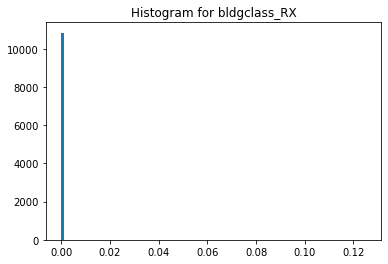

None


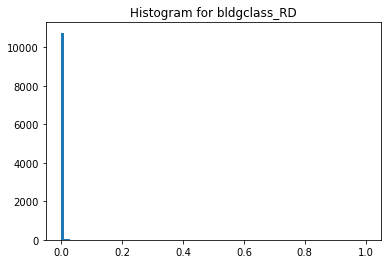

None


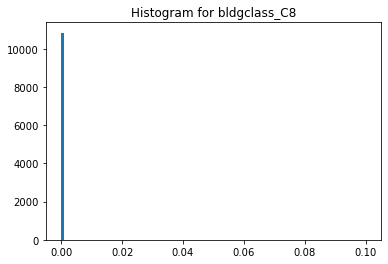

None


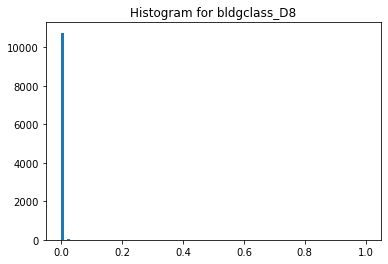

None


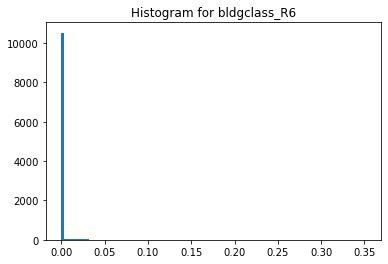

None


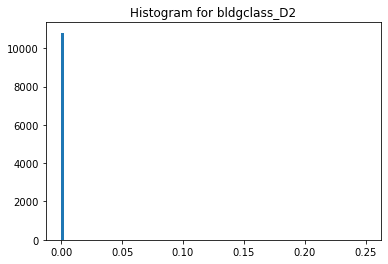

None


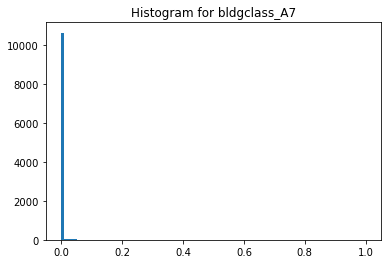

None


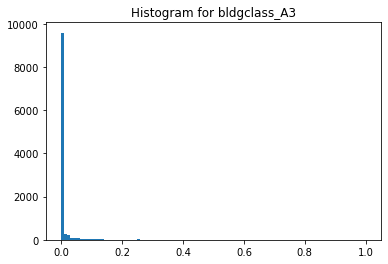

None


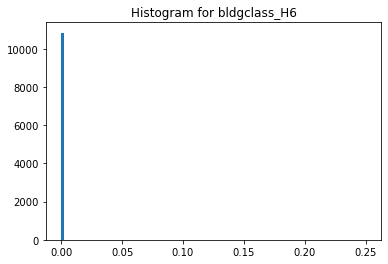

None


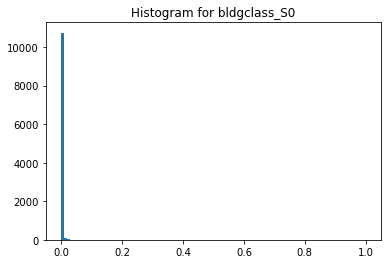

None


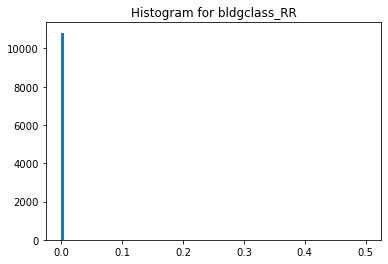

None


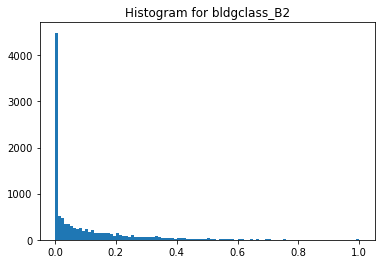

None


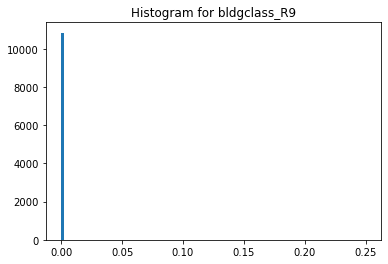

None


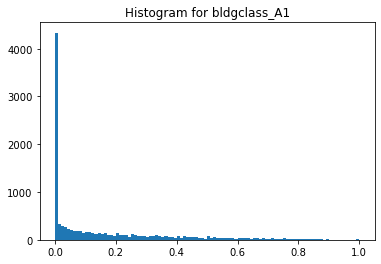

None


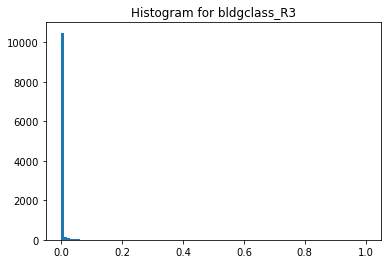

None


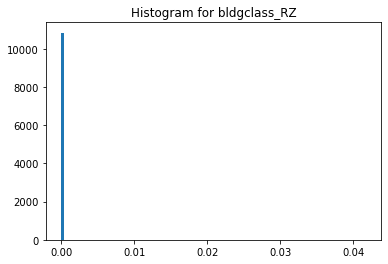

None


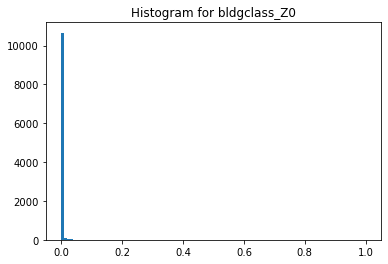

None


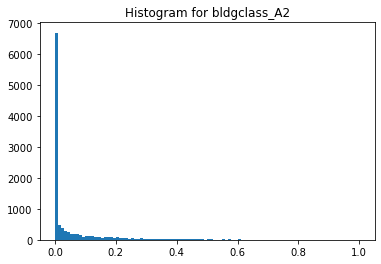

None


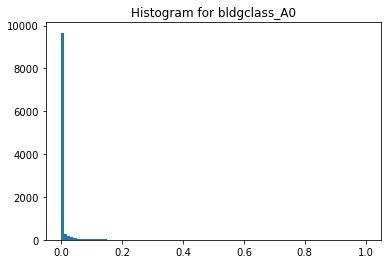

None


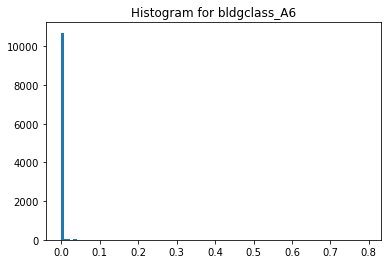

None


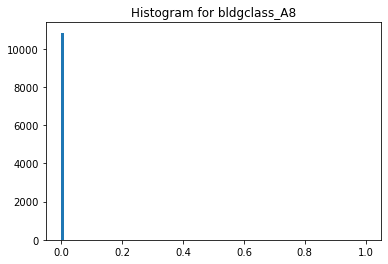

None


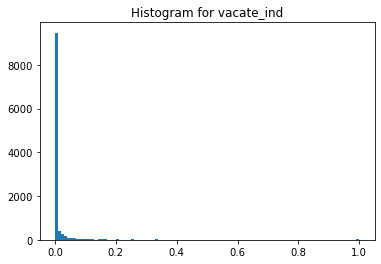

None


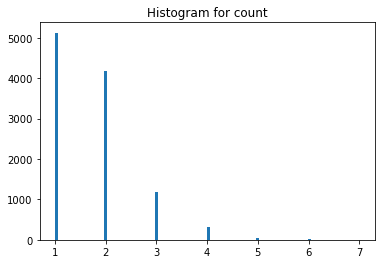

None


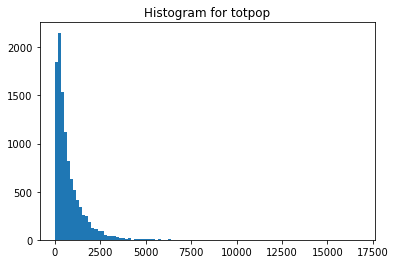

None


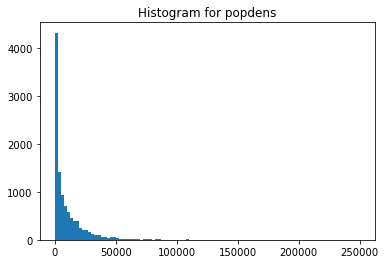

None


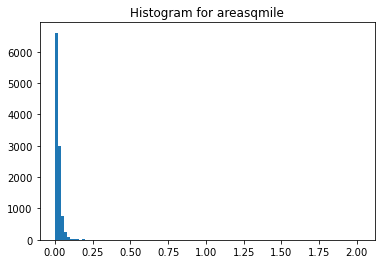

None


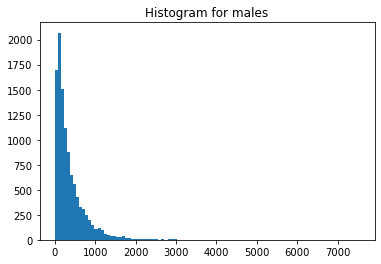

None


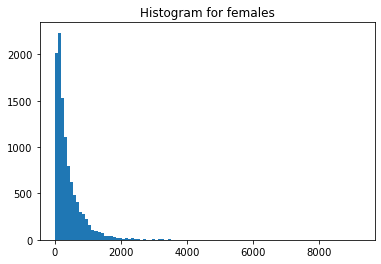

None


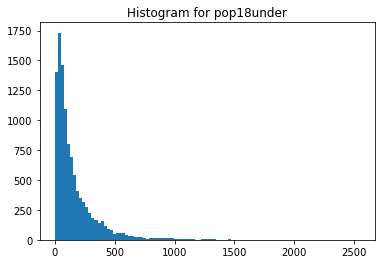

None


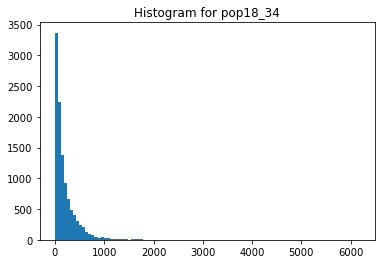

None


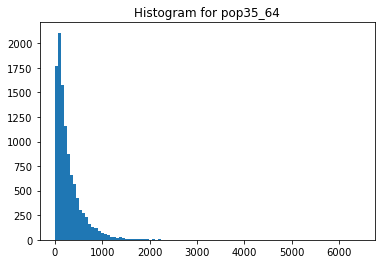

None


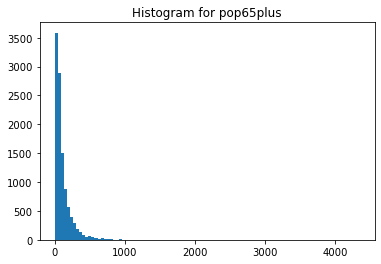

None


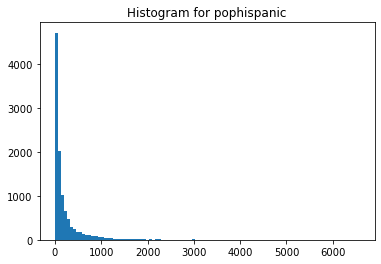

None


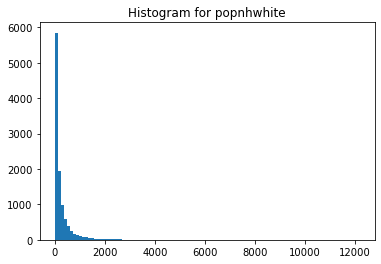

None


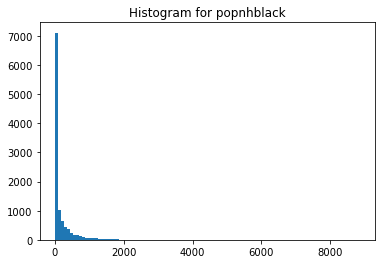

None


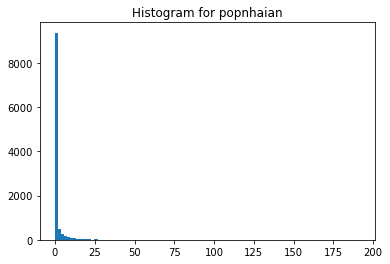

None


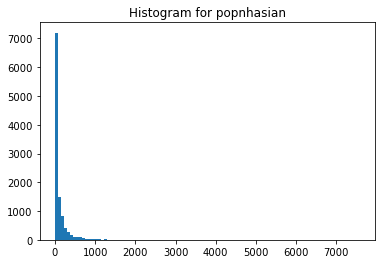

None


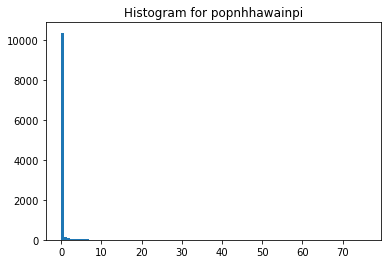

None


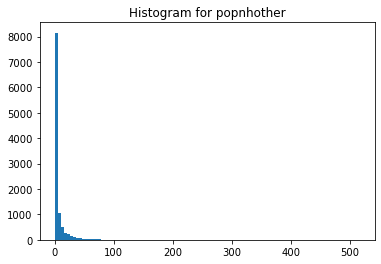

None


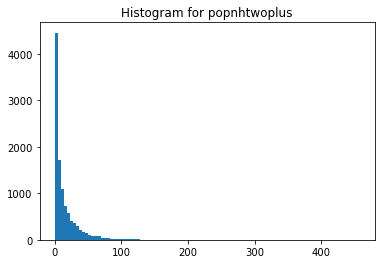

None


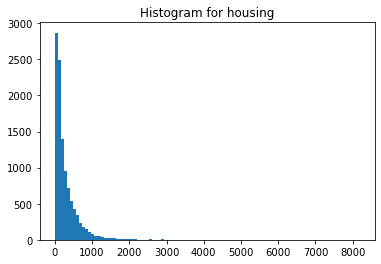

None


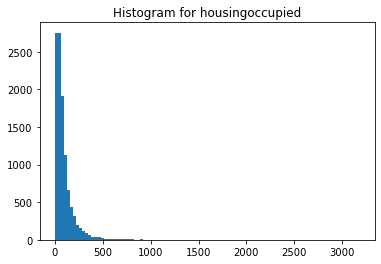

None


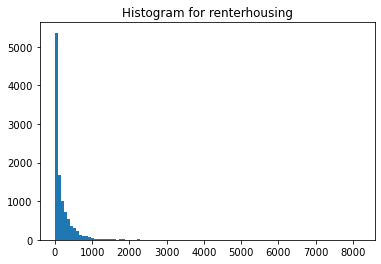

None


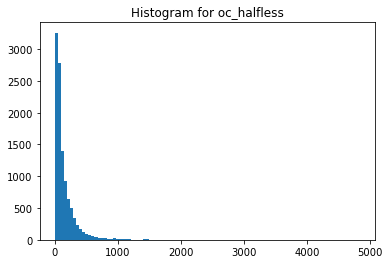

None


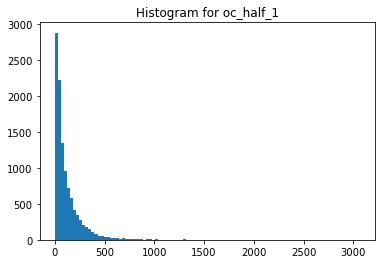

None


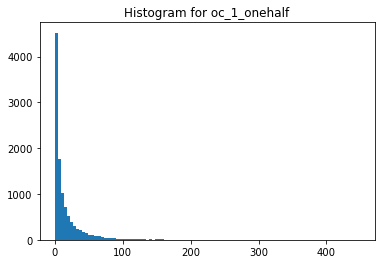

None


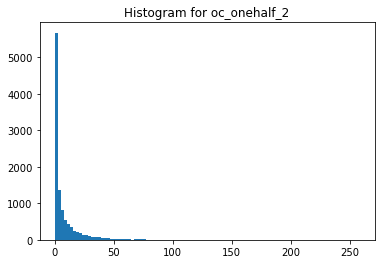

None


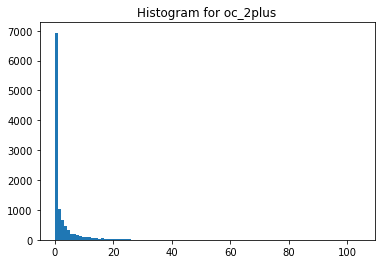

None


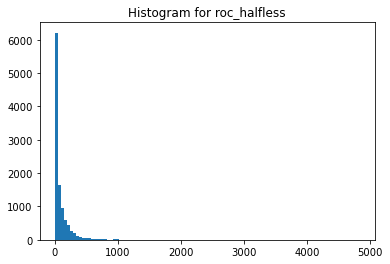

None


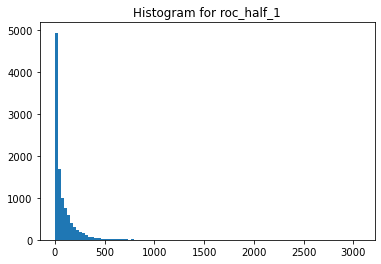

None


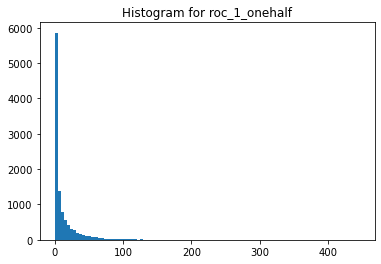

None


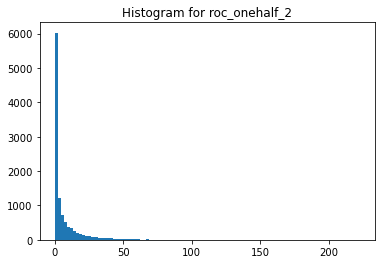

None


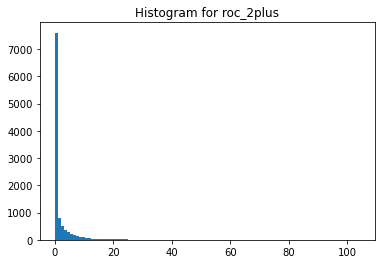

None


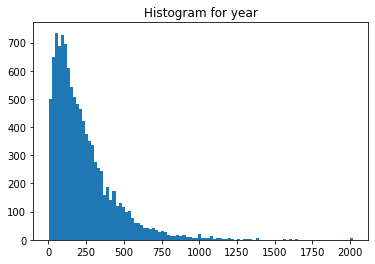

None


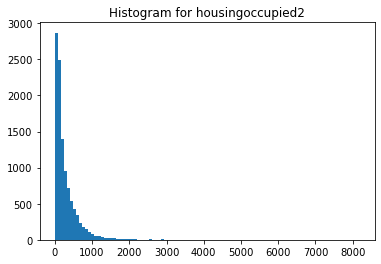

None


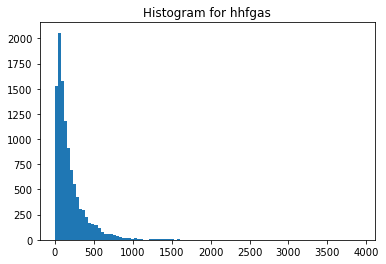

None


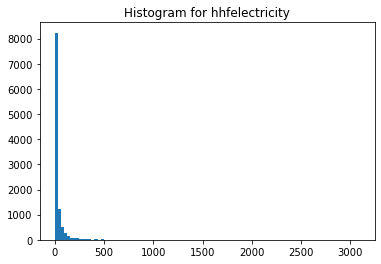

None


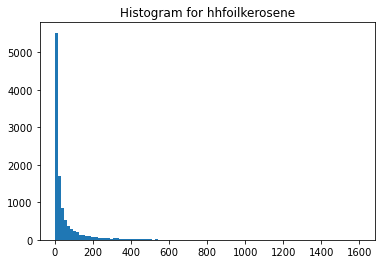

None


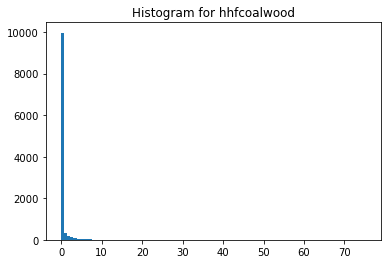

None


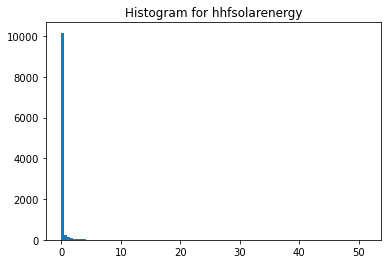

None


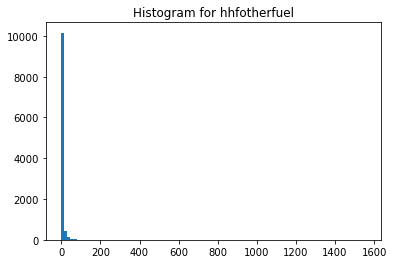

None


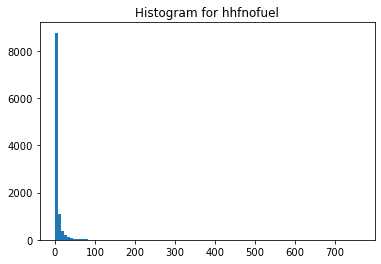

None


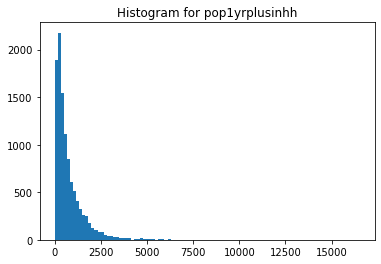

None


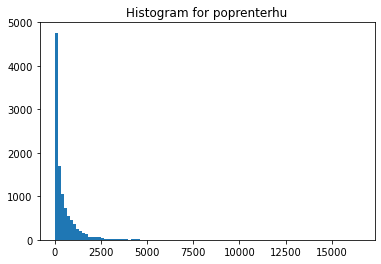

None


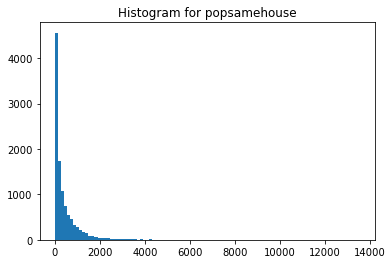

None


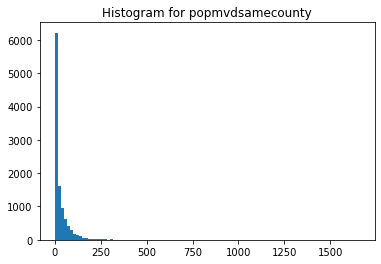

None


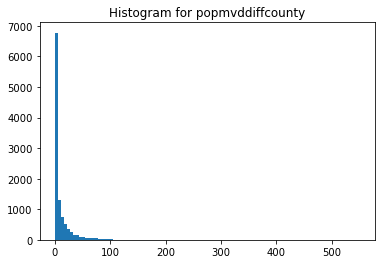

None


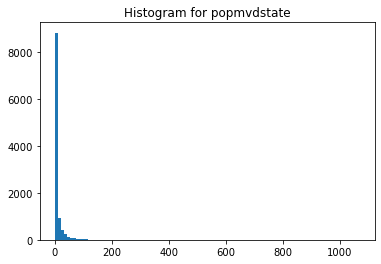

None


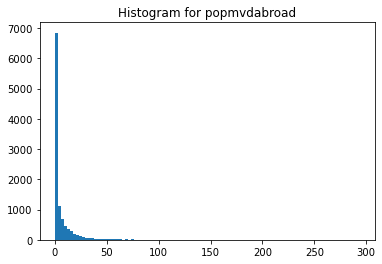

None


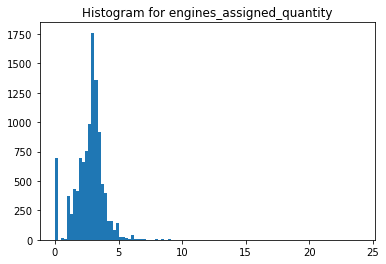

None


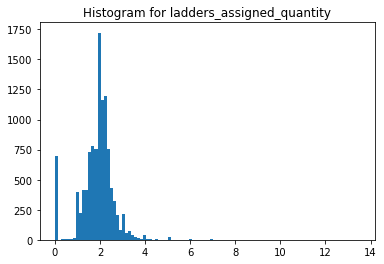

None


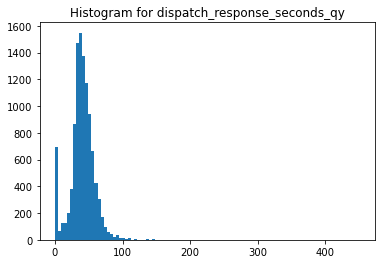

None


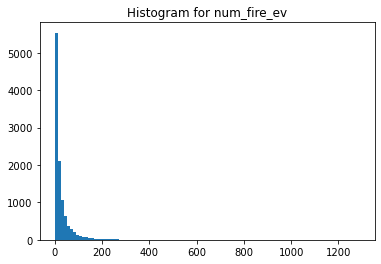

None


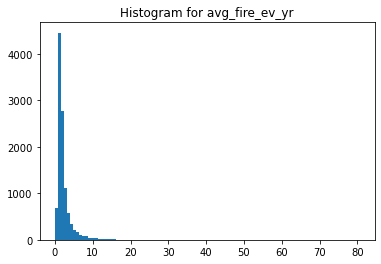

None


In [148]:
# discretize each variable to four equal-frequency bins (quartiles)
for i in df_box_disc.columns[1:]:
    if len(df_box_disc.loc[:, i].unique()) > 5:
        plt.hist(df_box_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_box_disc.loc[:, i] = pd.qcut(df_box_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [149]:
## important vars
impt_vars= outcomes[0:2] + ft1.loc[ft1['importance']>0, "variables"].tolist()
impt_vars

['dispatch_response_seconds_qy',
 'num_fire_ev',
 'hpd_b_c_vio',
 'popnhblack',
 'popdens',
 'unitsres',
 'exempttot',
 'unitstotal']

In [150]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [151]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('num_fire_ev', 'popdens'), ('num_fire_ev', 'dispatch_response_seconds_qy'), ('hpd_b_c_vio', 'num_fire_ev'), ('hpd_b_c_vio', 'popnhblack'), ('popnhblack', 'exempttot'), ('popdens', 'popnhblack'), ('unitsres', 'hpd_b_c_vio'), ('unitsres', 'exempttot'), ('unitsres', 'popdens'), ('unitstotal', 'unitsres'), ('unitstotal', 'dispatch_response_seconds_qy')]


In [152]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['dispatch_response_seconds_qy', 'num_fire_ev', 'hpd_b_c_vio', 'popnhblack', 'popdens', 'unitsres', 'exempttot', 'unitstotal']


In [153]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of num_fire_ev:
+----------------+---------------------+---------------------+---------------------+---------------------+
| hpd_b_c_vio    | hpd_b_c_vio(0)      | hpd_b_c_vio(1)      | hpd_b_c_vio(2)      | hpd_b_c_vio(3)      |
+----------------+---------------------+---------------------+---------------------+---------------------+
| num_fire_ev(0) | 0.5382871210158072  | 0.2856669318483161  | 0.15369013347291285 | 0.08081810961080223 |
+----------------+---------------------+---------------------+---------------------+---------------------+
| num_fire_ev(1) | 0.30040165846074113 | 0.3233227260673561  | 0.2374378434964669  | 0.08664283823140058 |
+----------------+---------------------+---------------------+---------------------+---------------------+
| num_fire_ev(2) | 0.12729981860585643 | 0.28407584195173696 | 0.35049725202826487 | 0.21902303415409055 |
+----------------+---------------------+---------------------+---------------------+---------------------+
| num_fire_ev(3) 

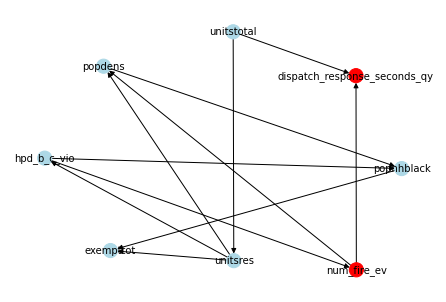

<Figure size 864x720 with 0 Axes>

In [159]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev', 'dispatch_response_seconds_qy'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig(os.join(plots, 'dag_1.png'), dpi = 300)

In [155]:
# don't want to condition on dispatch time for num_fire_ev
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev', 'dispatch_response_seconds_qy']]],
                    stochastic = False)
print(pred)

  0%|          | 0/603 [00:00<?, ?it/s]

      dispatch_response_seconds_qy  num_fire_ev
0                                1            3
1                                3            2
2                                3            2
3                                0            0
4                                0            0
...                            ...          ...
3255                             1            3
3256                             0            0
3257                             0            0
3258                             2            3
3259                             0            0

[3260 rows x 2 columns]


In [156]:
pred_proba = model.predict_probability(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev', 'dispatch_response_seconds_qy']]])
print(pred_proba)

       dispatch_response_seconds_qy_0  dispatch_response_seconds_qy_1  \
2261                         0.188316                        0.394618   
1859                         0.156123                        0.197197   
5182                         0.142870                        0.131833   
5343                         0.205044                        0.136986   
6263                         0.286100                        0.129205   
...                               ...                             ...   
3325                         0.169456                        0.455391   
4919                         0.413310                        0.210124   
6346                         0.205044                        0.136986   
2351                         0.116599                        0.204148   
10018                        0.328274                        0.289742   

       dispatch_response_seconds_qy_2  dispatch_response_seconds_qy_3  \
2261                         0.296475             

In [157]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
for i in impt_vars[0:2]:
    print("\nOS accuracy for: {}".format(i))
    print(((pred[i].reset_index(drop = True) == 3) == (test[i].reset_index(drop = True) == 3)).mean())
    
    pre_rec= precision_recall_fscore_support(np.asarray(test[i] == 3), 
                                      np.asarray(pred[i] == 3))
    
    print("Precision:", pre_rec[0][1])
    print("Recall:", pre_rec[1][1])
    
    roc_auc= roc_auc_score(np.array(test[i] == 3), 
                           pred_proba[i+"_3"])
    print("ROC AUC:", roc_auc)


OS accuracy for: dispatch_response_seconds_qy
0.7061349693251534
Precision: 0.34290843806104127
Recall: 0.24393358876117496
ROC AUC: 0.6975611126836886

OS accuracy for: num_fire_ev
0.7941717791411043
Precision: 0.559433962264151
Recall: 0.7440401505646174
ROC AUC: 0.8549705019482825


In [158]:
# prediction just for time to the fire
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['dispatch_response_seconds_qy']]], stochastic = True)
print(pred)

  0%|          | 0/1159 [00:00<?, ?it/s]

       dispatch_response_seconds_qy
2261                              1
1859                              2
5182                              0
5343                              2
6263                              1
...                             ...
3325                              0
4919                              0
6346                              3
2351                              2
10018                             3

[3260 rows x 1 columns]


In [78]:
print("\nOS accuracy top 25th percentile time to the fire, includes num_fire_ev as predictor")
print(((pred['dispatch_response_seconds_qy'].reset_index(drop = True) == 3) == \
       (test['dispatch_response_seconds_qy'].reset_index(drop = True) == 3)).mean())


OS accuracy top 25th percentile time to the fire, includes num_fire_ev as predictor
0.660122699386503


### Predict with binary outcome

In [86]:
train_bin= train.copy()
train_bin["num_fire_ev"]= np.where(train_bin["num_fire_ev"] == 3, 1, 0)
train_bin= train_bin.drop("dispatch_response_seconds_qy", axis =1)

# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train_bin)
best_model = hc.estimate(scoring_method=BicScore(train_bin))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('num_fire_ev', 'popdens'), ('hpd_b_c_vio', 'popdens'), ('hpd_b_c_vio', 'num_fire_ev'), ('hpd_b_c_vio', 'popnhblack'), ('popnhblack', 'exempttot'), ('popdens', 'popnhblack'), ('unitsres', 'hpd_b_c_vio'), ('unitsres', 'exempttot'), ('unitsres', 'num_fire_ev'), ('unitstotal', 'unitsres')]


In [87]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['num_fire_ev', 'hpd_b_c_vio', 'popnhblack', 'popdens', 'unitsres', 'exempttot', 'unitstotal']


In [88]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train_bin, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of num_fire_ev:
+----------------+---------------------+-----+--------------------+--------------------+
| hpd_b_c_vio    | hpd_b_c_vio(0)      | ... | hpd_b_c_vio(3)     | hpd_b_c_vio(3)     |
+----------------+---------------------+-----+--------------------+--------------------+
| unitsres       | unitsres(0)         | ... | unitsres(2)        | unitsres(3)        |
+----------------+---------------------+-----+--------------------+--------------------+
| num_fire_ev(0) | 0.9779433245690914  | ... | 0.4517761033369214 | 0.3355560012032488 |
+----------------+---------------------+-----+--------------------+--------------------+
| num_fire_ev(1) | 0.02205667543090856 | ... | 0.5482238966630786 | 0.6644439987967512 |
+----------------+---------------------+-----+--------------------+--------------------+
CPD of popdens:
+-------------+----------------------+-----+---------------------+----------------------+
| hpd_b_c_vio | hpd_b_c_vio(0)       | ... | hpd_b_c_vio(3)      | hpd_b_

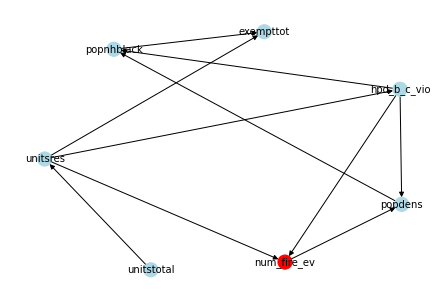

<Figure size 252x216 with 0 Axes>

In [130]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev', 'dispatch_response_seconds_qy'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (3.5,3))
fig.savefig(os.join(plots, 'dag_predict.png'), dpi = 300)

In [96]:
pred_proba = model.predict_probability(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev']]])
print(pred_proba)

       num_fire_ev_0  num_fire_ev_1
2261        0.262532       0.737468
1859        0.702600       0.297400
5182        0.967593       0.032407
5343        0.968781       0.031219
6263        0.989372       0.010628
...              ...            ...
3325        0.179091       0.820909
4919        0.936751       0.063249
6346        0.968781       0.031219
2351        0.664743       0.335257
10018       0.724347       0.275653

[3260 rows x 2 columns]


In [116]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
for i in impt_vars[1:2]:
    print("\nOS accuracy for: {}".format(i))
    print(((pred_proba[i+"_1"] > 0.5) == (test[i] == 3)).mean())
     
    pre_rec= precision_recall_fscore_support(np.asarray(test[i]==3),pred_proba[i+"_1"] > 0.5)
    print("Precision:", pre_rec[0][1])
    print("Recall:", pre_rec[1][1])
    
    roc_auc= roc_auc_score(np.array(test[i] == 3), 
                           pred_proba[i+"_1"])
    print("ROC AUC:", roc_auc)


OS accuracy for: num_fire_ev
0.8337423312883435
Precision: 0.7007874015748031
Recall: 0.5583437892095358
ROC AUC: 0.8693479048258008


### Re-run Bayes Net with Feature Selection from LASSO

In [160]:
impt_vars= outcomes[0:2] + lasso_coef.loc[lasso_coef["coef_alpha_3"] != 0, "Features"].tolist()

In [161]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [162]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('num_fire_ev', 'dispatch_response_seconds_qy'), ('viol_count_per_unit', 'holc_D'), ('viol_count_per_unit', 'popnhblack'), ('viol_count_per_unit', 'hpd_fire_vio'), ('popdens', 'num_fire_ev'), ('numfloors', 'hhfoilkerosene'), ('numfloors', 'hpd_fire_vio_per_unit'), ('numfloors', 'roc_half_1'), ('popsamehouse', 'popdens'), ('popsamehouse', 'popnhblack'), ('popsamehouse', 'hpd_fire_vio_per_unit'), ('popsamehouse', 'viol_count_per_unit'), ('hpd_fire_vio', 'num_fire_ev'), ('hpd_fire_vio', 'dispatch_response_seconds_qy'), ('roc_half_1', 'popsamehouse'), ('hhfoilkerosene', 'roc_half_1'), ('hhfoilkerosene', 'popdens'), ('hpd_fire_vio_per_unit', 'hpd_fire_vio'), ('hpd_fire_vio_per_unit', 'viol_count_per_unit'), ('hpd_fire_vio_per_unit', 'holc_D'), ('average_energy_usage_mi', 'numfloors'), ('average_energy_usage_mi', 'hpd_fire_vio'), ('average_energy_usage_mi', 'hhfoilkerosene'), ('average_energy_usage_mi', 'num_fire_ev'), ('average_energy_usage_mi', 'holc_D')]


In [163]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['dispatch_response_seconds_qy', 'num_fire_ev', 'viol_count_per_unit', 'popdens', 'popnhblack', 'numfloors', 'popsamehouse', 'hpd_fire_vio', 'roc_half_1', 'holc_D', 'hhfoilkerosene', 'hpd_fire_vio_per_unit', 'average_energy_usage_mi']


In [164]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of num_fire_ev:
+-------------------------+----------------------------+-----+----------------------------+
| average_energy_usage_mi | average_energy_usage_mi(0) | ... | average_energy_usage_mi(1) |
+-------------------------+----------------------------+-----+----------------------------+
| hpd_fire_vio            | hpd_fire_vio(0)            | ... | hpd_fire_vio(1)            |
+-------------------------+----------------------------+-----+----------------------------+
| popdens                 | popdens(0)                 | ... | popdens(3)                 |
+-------------------------+----------------------------+-----+----------------------------+
| num_fire_ev(0)          | 0.4798692360633173         | ... | 0.015881973556917124       |
+-------------------------+----------------------------+-----+----------------------------+
| num_fire_ev(1)          | 0.23761183757742602        | ... | 0.059738793937439534       |
+-------------------------+----------------------------+----

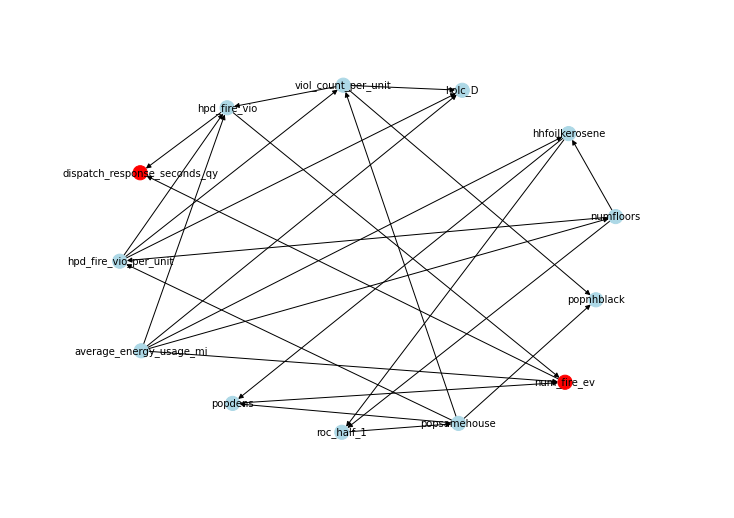

In [181]:
import networkx as nx
import pylab as plt
fig = plt.figure(figsize=(10,7))

values = ['red' if n in ['num_fire_ev', 'dispatch_response_seconds_qy'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

#plt.figure(figsize = (16,10))
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])

fig.savefig(os.join(plots, 'dag_2.png'), dpi = 300)

In [67]:
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev', 'dispatch_response_seconds_qy']]])
print(pred)

  0%|          | 0/1751 [00:00<?, ?it/s]

      num_fire_ev  dispatch_response_seconds_qy
0               3                             1
1               2                             2
2               2                             2
3               0                             0
4               0                             0
...           ...                           ...
3255            3                             1
3256            0                             0
3257            0                             0
3258            2                             2
3259            0                             0

[3260 rows x 2 columns]


In [68]:
for i in impt_vars[0:2]:
    print("\nOS accuracy for: {}".format(i))
    print((pred[i].reset_index(drop = True) == test[i].reset_index(drop = True)).mean())


OS accuracy for: dispatch_response_seconds_qy
0.3398773006134969

OS accuracy for: num_fire_ev
0.4803680981595092


In [69]:
# prediction just for time to the fire
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['dispatch_response_seconds_qy']]], stochastic = True)
print(pred)

  0%|          | 0/2194 [00:00<?, ?it/s]

       dispatch_response_seconds_qy
2261                              3
1859                              3
5182                              2
5343                              2
6263                              0
...                             ...
3325                              3
4919                              3
6346                              0
2351                              1
10018                             2

[3260 rows x 1 columns]


In [70]:
print("\nOS accuracy time to the fire, includes num_fire_ev as predictor")
print((pred['dispatch_response_seconds_qy'].reset_index(drop = True) == test['dispatch_response_seconds_qy'].reset_index(drop = True)).mean())


OS accuracy time to the fire, includes num_fire_ev as predictor
0.3079754601226994


### PC Method for Causal Model calculations

In [182]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

In [183]:
## important vars
impt_vars= outcomes[1:2] + ft1.loc[ft1['importance']>0, "variables"].tolist()
impt_vars

['num_fire_ev',
 'hpd_b_c_vio',
 'popnhblack',
 'popdens',
 'unitsres',
 'exempttot',
 'unitstotal']

In [184]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, impt_vars], test_size=0.3, random_state=999)
train.head()

,num_fire_ev,hpd_b_c_vio,popnhblack,popdens,unitsres,exempttot,unitstotal
2058,0,1,0,1,1,2,2
5077,2,2,2,0,0,0,0
5775,2,2,2,2,1,0,1
5959,1,0,1,1,0,2,0
6683,1,2,1,3,3,2,2


In [185]:
pc_est = PC(train)

# Step 1: construct undirected skeleton
skel, separating_sets = pc_est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('num_fire_ev', 'hpd_b_c_vio'), ('num_fire_ev', 'popnhblack'), ('num_fire_ev', 'popdens'), ('hpd_b_c_vio', 'popnhblack'), ('hpd_b_c_vio', 'popdens'), ('hpd_b_c_vio', 'unitsres'), ('hpd_b_c_vio', 'exempttot'), ('hpd_b_c_vio', 'unitstotal'), ('popnhblack', 'popdens'), ('popnhblack', 'exempttot'), ('popdens', 'unitsres'), ('popdens', 'exempttot'), ('unitsres', 'exempttot'), ('unitsres', 'unitstotal'), ('exempttot', 'unitstotal')]


In [186]:
# Step 2: partially directed acyclic graph 
pdag = pc_est.skeleton_to_pdag(skel, separating_sets)
print("PDAG edges:       ", pdag.edges())

PDAG edges:        [('popdens', 'unitsres'), ('popdens', 'num_fire_ev'), ('popdens', 'popnhblack'), ('popdens', 'hpd_b_c_vio'), ('unitsres', 'exempttot'), ('unitsres', 'hpd_b_c_vio'), ('exempttot', 'popdens'), ('unitstotal', 'exempttot'), ('unitstotal', 'hpd_b_c_vio'), ('unitstotal', 'unitsres'), ('num_fire_ev', 'popnhblack'), ('num_fire_ev', 'hpd_b_c_vio'), ('popnhblack', 'exempttot'), ('popnhblack', 'hpd_b_c_vio'), ('hpd_b_c_vio', 'exempttot')]


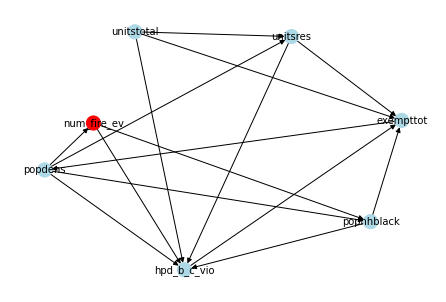

<Figure size 864x720 with 0 Axes>

In [188]:
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev'] else 'lightblue' for n in pdag.nodes()]
# use networkx to draw DAG
nx.draw(pdag, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig(os.join(plots, 'pdag_box.png'), dpi = 300)

In [189]:
model = pc_est.estimate()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

DAG edges:         [('popdens', 'unitsres'), ('popdens', 'hpd_b_c_vio'), ('popdens', 'num_fire_ev'), ('popdens', 'popnhblack'), ('unitsres', 'hpd_b_c_vio'), ('unitsres', 'exempttot'), ('exempttot', 'popdens'), ('unitstotal', 'exempttot'), ('unitstotal', 'hpd_b_c_vio'), ('unitstotal', 'unitsres'), ('num_fire_ev', 'popnhblack'), ('num_fire_ev', 'hpd_b_c_vio'), ('popnhblack', 'exempttot'), ('popnhblack', 'hpd_b_c_vio'), ('hpd_b_c_vio', 'exempttot')]


C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\pgmpy\base\DAG.py:1187: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


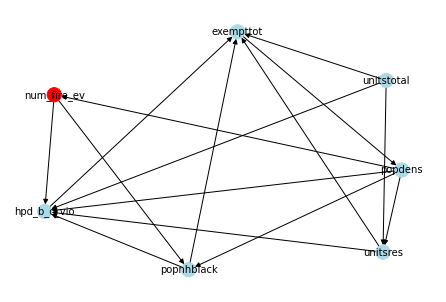

<Figure size 864x720 with 0 Axes>

In [191]:
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig(os.join(plots, 'model_pdag_est.png'), dpi = 300)